# Вопросы по датасету
- Необходимо предсказать рейтинг компании на основании некоторых данных, полученных на основе полученных данных по кол-ву интервью в данной компании, зарплате и т.д.
- 10000 данных, 10 признаков.
- Company_name, Highly_rated_for, Critically_rated_for - категориальные; Description - Текстовый; Ratings, Total_reviews, Avg_salary, Interviews_taken, Total_jobs_available, Total_benefits - количественные.
- Были пропущенные значения они были в виде "--".
- Для обучения мы будем использовать переменную Raings, которую переведём в категориальную переменную User_Ratings, разделённую на 3 класса:
    * Not_Recommended
    * Company_with_some_issues
    * Recommended_Company
- Разбиение User_Ratings: 
    * 2    4853
    * 1    2414
    * 0      38
- Стандартизация проведена с помощью StandartScaler из библиотеки Sklearn.
- Логистическая регрессия оказалась хуже по точности 0.6124794745484401
- Точность Random Forest = 0.8177339901477833
- MLPClassifier лучший F1_score = 0.8166752907440687 с параметрами: neurons=20, alpha=0.0005
- Воспользуемся перебалансировкой User_Ratings, для того, чтобы лучше определять наименьший по кол-во данных класс с помощью RandomOverSampler из библиотеки imblearn.

# Загрузка данных

In [78]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import random
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV


In [79]:
import opendatasets as od
url = "https://www.kaggle.com/datasets/bhavikjikadara/top-worlds-companies"
od.download(url)

Skipping, found downloaded files in ".\top-worlds-companies" (use force=True to force download)


- Company_name: The name of the company listed on the Ambition Box.
- Description: A brief description of the company, often sourced from its profile or website.
- Ratings: The overall rating of the company as provided by users on Ambition Box.
- Highly_rated_for: Areas or aspects of the company that are highly rated by users.
- Critically_rated_for: Areas or aspects of the company that are critically rated by users.
- Total_reviews: The total number of reviews submitted for the company on Ambition Box.
- Avg_salary: The average salary reported for the company, if available.
- Interviews_taken: The number of interviews conducted by the company, if available.
- Total_jobs_available: The total number of job positions available within the company.
- Total_benefits: Information on benefits offered by the company, if provided.

In [80]:
import pandas as pd
import os
pwd = os.getcwd()
dataset = pd.read_csv(pwd + '/top-worlds-companies/companies.csv')
dataset.head()

,Company_name,Description,Ratings,Highly_rated_for,Critically_rated_for,Total_reviews,Avg_salary,Interviews_taken,Total_jobs_available,Total_benefits
0,TCS,IT Services & Consulting | 1 Lakh+ Employees |...,3.8,"Job Security, Work Life Balance","Promotions / Appraisal, Salary & Benefits",73.1k,856.9k,6.1k,847,11.5k
1,Accenture,IT Services & Consulting | 1 Lakh+ Employees |...,4.0,"Company Culture, Skill Development / Learning,...",NaN,46.4k,584.6k,4.3k,9.9k,7.1k
2,Cognizant,IT Services & Consulting | 1 Lakh+ Employees |...,3.9,Skill Development / Learning,Promotions / Appraisal,41.7k,561.5k,3.6k,460,5.8k
3,Wipro,IT Services & Consulting | 1 Lakh+ Employees |...,3.8,Job Security,"Promotions / Appraisal, Salary & Benefits",39.2k,427.4k,3.7k,405,5k
4,Capgemini,IT Services & Consulting | 1 Lakh+ Employees |...,3.9,"Job Security, Work Life Balance, Skill Develop...","Promotions / Appraisal, Salary & Benefits",34k,414.4k,2.8k,719,4k


## Информация о датасете

In [81]:
dataset.describe()

,Ratings
count,10000.000000
mean,3.894710
std,0.385894
min,1.300000
25%,3.700000
50%,3.900000
75%,4.100000
max,5.000000


In [82]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company_name          10000 non-null  object 
 1   Description           10000 non-null  object 
 2   Ratings               10000 non-null  float64
 3   Highly_rated_for      9908 non-null   object 
 4   Critically_rated_for  2807 non-null   object 
 5   Total_reviews         10000 non-null  object 
 6   Avg_salary            10000 non-null  object 
 7   Interviews_taken      10000 non-null  object 
 8   Total_jobs_available  10000 non-null  object 
 9   Total_benefits        10000 non-null  object 
dtypes: float64(1), object(9)
memory usage: 781.4+ KB


In [83]:
dataset[['Company Field', 
      'Total Employees', 'Other Information' , 
      'Company Origin', 'Company Location']] = dataset['Description'].str.split('|', expand=True)
dataset = dataset.drop(columns=['Other Information', 'Company Origin', 'Company Location'], axis=1)
dataset['Years_old'] = dataset['Description'].str.extract(r'(\d+ years old)')
dataset['Years Old'] = dataset['Years_old'].str.extract(r'(\d+)').astype(float)
dataset['Years Old'] = pd.to_numeric(dataset['Years Old'] , errors = 'coerce').astype(int, errors = 'ignore')
dataset = dataset.drop(columns=['Years_old'], axis=1)
dataset = dataset.drop(['Description'], axis=1)

In [84]:
dataset.head()

,Company_name,Ratings,Highly_rated_for,Critically_rated_for,Total_reviews,Avg_salary,Interviews_taken,Total_jobs_available,Total_benefits,Company Field,Total Employees,Years Old
0,TCS,3.8,"Job Security, Work Life Balance","Promotions / Appraisal, Salary & Benefits",73.1k,856.9k,6.1k,847,11.5k,IT Services & Consulting,1 Lakh+ Employees,56.0
1,Accenture,4.0,"Company Culture, Skill Development / Learning,...",NaN,46.4k,584.6k,4.3k,9.9k,7.1k,IT Services & Consulting,1 Lakh+ Employees,35.0
2,Cognizant,3.9,Skill Development / Learning,Promotions / Appraisal,41.7k,561.5k,3.6k,460,5.8k,IT Services & Consulting,1 Lakh+ Employees,30.0
3,Wipro,3.8,Job Security,"Promotions / Appraisal, Salary & Benefits",39.2k,427.4k,3.7k,405,5k,IT Services & Consulting,1 Lakh+ Employees,79.0
4,Capgemini,3.9,"Job Security, Work Life Balance, Skill Develop...","Promotions / Appraisal, Salary & Benefits",34k,414.4k,2.8k,719,4k,IT Services & Consulting,1 Lakh+ Employees,57.0


In [85]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company_name          10000 non-null  object 
 1   Ratings               10000 non-null  float64
 2   Highly_rated_for      9908 non-null   object 
 3   Critically_rated_for  2807 non-null   object 
 4   Total_reviews         10000 non-null  object 
 5   Avg_salary            10000 non-null  object 
 6   Interviews_taken      10000 non-null  object 
 7   Total_jobs_available  10000 non-null  object 
 8   Total_benefits        10000 non-null  object 
 9   Company Field         10000 non-null  object 
 10  Total Employees       9866 non-null   object 
 11  Years Old             9217 non-null   float64
dtypes: float64(2), object(10)
memory usage: 937.6+ KB


# Работа с данными

In [86]:
columns_with_dashes = []
for col in dataset.columns:
    if (dataset[col] == '--').any():
        num_dashes = (dataset[col] == '--').sum()
        print(f"Column '{col}' has {num_dashes} '--' values.")
        columns_with_dashes.append(col)

dataset[columns_with_dashes] = dataset[columns_with_dashes].replace('--', np.nan)
columns_to_convert = ['Total_reviews', 'Avg_salary', 'Interviews_taken', 'Total_jobs_available', 'Total_benefits']
for col in columns_to_convert:
    dataset[col] = dataset[col].str.replace('k', '').astype(float) * 1000

Column 'Avg_salary' has 2 '--' values.
Column 'Interviews_taken' has 219 '--' values.
Column 'Total_jobs_available' has 3923 '--' values.
Column 'Total_benefits' has 79 '--' values.


In [87]:
dataset['Avg_salary'].value_counts()

Avg_salary
1100.0      321
1200.0      293
1300.0      255
1000.0      219
1400.0      182
1500.0      164
1600.0      154
1700.0      144
1800.0      132
2100.0       90
2000.0       90
1900.0       89
2200.0       83
2300.0       70
2400.0       63
2500.0       60
2800.0       59
3000.0       53
2700.0       52
2600.0       50
3100.0       47
3500.0       45
3900.0       41
3300.0       40
3600.0       39
2900.0       31
3800.0       31
3200.0       29
456000.0     27
4000.0       27
4200.0       24
4100.0       24
3700.0       24
572000.0     21
3400.0       21
587000.0     21
4500.0       21
4800.0       21
4400.0       21
451000.0     20
467000.0     20
5600.0       19
331000.0     19
400000.0     19
538000.0     19
640000.0     19
5200.0       18
401000.0     18
5400.0       18
4900.0       18
336000.0     18
381000.0     17
732000.0     17
5800.0       17
565000.0     17
413000.0     17
388000.0     16
5300.0       16
721000.0     16
399000.0     16
441000.0     16
597000.0     

In [88]:
dataset.head()

,Company_name,Ratings,Highly_rated_for,Critically_rated_for,Total_reviews,Avg_salary,Interviews_taken,Total_jobs_available,Total_benefits,Company Field,Total Employees,Years Old
0,TCS,3.8,"Job Security, Work Life Balance","Promotions / Appraisal, Salary & Benefits",73100.0,856900.0,6100.0,847000.0,11500.0,IT Services & Consulting,1 Lakh+ Employees,56.0
1,Accenture,4.0,"Company Culture, Skill Development / Learning,...",NaN,46400.0,584600.0,4300.0,9900.0,7100.0,IT Services & Consulting,1 Lakh+ Employees,35.0
2,Cognizant,3.9,Skill Development / Learning,Promotions / Appraisal,41700.0,561500.0,3600.0,460000.0,5800.0,IT Services & Consulting,1 Lakh+ Employees,30.0
3,Wipro,3.8,Job Security,"Promotions / Appraisal, Salary & Benefits",39200.0,427400.0,3700.0,405000.0,5000.0,IT Services & Consulting,1 Lakh+ Employees,79.0
4,Capgemini,3.9,"Job Security, Work Life Balance, Skill Develop...","Promotions / Appraisal, Salary & Benefits",34000.0,414400.0,2800.0,719000.0,4000.0,IT Services & Consulting,1 Lakh+ Employees,57.0


In [89]:
dataset['Avg_salary'] = pd.to_numeric(dataset['Avg_salary'], errors='coerce')
dataset['Avg_salary'] = dataset['Avg_salary'] * 0.012
dataset['Total_reviews'] = pd.to_numeric(dataset['Total_reviews'], errors='coerce')
dataset['Interviews_taken'] = pd.to_numeric(dataset['Interviews_taken'], errors='coerce')
dataset['Total_jobs_available'] = pd.to_numeric(dataset['Total_jobs_available'], errors='coerce')
dataset['Total_benefits'] = pd.to_numeric(dataset['Total_benefits'], errors='coerce')

In [90]:
dataset.head()

,Company_name,Ratings,Highly_rated_for,Critically_rated_for,Total_reviews,Avg_salary,Interviews_taken,Total_jobs_available,Total_benefits,Company Field,Total Employees,Years Old
0,TCS,3.8,"Job Security, Work Life Balance","Promotions / Appraisal, Salary & Benefits",73100.0,10282.8,6100.0,847000.0,11500.0,IT Services & Consulting,1 Lakh+ Employees,56.0
1,Accenture,4.0,"Company Culture, Skill Development / Learning,...",NaN,46400.0,7015.2,4300.0,9900.0,7100.0,IT Services & Consulting,1 Lakh+ Employees,35.0
2,Cognizant,3.9,Skill Development / Learning,Promotions / Appraisal,41700.0,6738.0,3600.0,460000.0,5800.0,IT Services & Consulting,1 Lakh+ Employees,30.0
3,Wipro,3.8,Job Security,"Promotions / Appraisal, Salary & Benefits",39200.0,5128.8,3700.0,405000.0,5000.0,IT Services & Consulting,1 Lakh+ Employees,79.0
4,Capgemini,3.9,"Job Security, Work Life Balance, Skill Develop...","Promotions / Appraisal, Salary & Benefits",34000.0,4972.8,2800.0,719000.0,4000.0,IT Services & Consulting,1 Lakh+ Employees,57.0


In [91]:
splitted_higly_rated = dataset['Highly_rated_for'].str.split(',',expand=True)
splitted_higly_rated.columns = ['Highly_first_rated', 'Highly_second_rated', 'Highly_third_rated']
splitted_higly_rated.head()

,Highly_first_rated,Highly_second_rated,Highly_third_rated
0,Job Security,Work Life Balance,None
1,Company Culture,Skill Development / Learning,Job Security
2,Skill Development / Learning,None,None
3,Job Security,None,None
4,Job Security,Work Life Balance,Skill Development / Learning


In [92]:
final_dataset = pd.concat([dataset,splitted_higly_rated],axis=1)
final_dataset.drop('Highly_rated_for', axis=1, inplace=True)
final_dataset.drop('Critically_rated_for',axis=1, inplace=True)
final_dataset.head()

,Company_name,Ratings,Total_reviews,Avg_salary,Interviews_taken,Total_jobs_available,Total_benefits,Company Field,Total Employees,Years Old,Highly_first_rated,Highly_second_rated,Highly_third_rated
0,TCS,3.8,73100.0,10282.8,6100.0,847000.0,11500.0,IT Services & Consulting,1 Lakh+ Employees,56.0,Job Security,Work Life Balance,None
1,Accenture,4.0,46400.0,7015.2,4300.0,9900.0,7100.0,IT Services & Consulting,1 Lakh+ Employees,35.0,Company Culture,Skill Development / Learning,Job Security
2,Cognizant,3.9,41700.0,6738.0,3600.0,460000.0,5800.0,IT Services & Consulting,1 Lakh+ Employees,30.0,Skill Development / Learning,None,None
3,Wipro,3.8,39200.0,5128.8,3700.0,405000.0,5000.0,IT Services & Consulting,1 Lakh+ Employees,79.0,Job Security,None,None
4,Capgemini,3.9,34000.0,4972.8,2800.0,719000.0,4000.0,IT Services & Consulting,1 Lakh+ Employees,57.0,Job Security,Work Life Balance,Skill Development / Learning


In [93]:
final_dataset.dtypes

Company_name             object
Ratings                 float64
Total_reviews           float64
Avg_salary              float64
Interviews_taken        float64
Total_jobs_available    float64
Total_benefits          float64
Company Field            object
Total Employees          object
Years Old               float64
Highly_first_rated       object
Highly_second_rated      object
Highly_third_rated       object
dtype: object

In [94]:
final_dataset.describe()

,Ratings,Total_reviews,Avg_salary,Interviews_taken,Total_jobs_available,Total_benefits,Years Old
count,10000.000000,10000.000000,9998.00000,9781.000000,6077.000000,9921.000000,9217.000000
mean,3.894710,194255.550000,4059.15099,20444.085472,28490.686194,43258.391291,39.853098
std,0.385894,177098.055284,3814.00877,47911.045887,67683.459599,81945.147593,76.471579
min,1.300000,1000.000000,12.00000,1000.000000,1000.000000,1000.000000,1.000000
25%,3.700000,88000.000000,32.40000,4000.000000,3000.000000,11000.000000,17.000000
50%,3.900000,129000.000000,4104.00000,8000.000000,9000.000000,18000.000000,28.000000
75%,4.100000,235000.000000,7116.00000,17000.000000,25000.000000,38000.000000,45.000000
max,5.000000,999000.000000,11988.00000,972000.000000,981000.000000,973000.000000,2024.000000


# Продолжение работы с данными

In [95]:
final_dataset.drop_duplicates(inplace=True)
final_dataset.reset_index(drop=True, inplace=True)

In [96]:
for category in ('Highly_first_rated', 'Highly_second_rated', 'Highly_third_rated'):
    dummies = pd.get_dummies(final_dataset[category])
    dummies.columns = ["{} + {}".format(category, column) for column in dummies.columns.tolist()]
    final_dataset = pd.concat((final_dataset, dummies), axis=1)
    final_dataset.drop([category], axis=1, inplace=True)
final_dataset.columns

Index(['Company_name', 'Ratings', 'Total_reviews', 'Avg_salary',
       'Interviews_taken', 'Total_jobs_available', 'Total_benefits',
       'Company Field', 'Total Employees', 'Years Old',
       'Highly_first_rated + Company Culture',
       'Highly_first_rated + Job Security',
       'Highly_first_rated + Promotions / Appraisal',
       'Highly_first_rated + Salary & Benefits',
       'Highly_first_rated + Skill Development / Learning',
       'Highly_first_rated + Work Life Balance',
       'Highly_first_rated + Work Satisfaction',
       'Highly_second_rated +  Company Culture',
       'Highly_second_rated +  Job Security',
       'Highly_second_rated +  Promotions / Appraisal',
       'Highly_second_rated +  Salary & Benefits',
       'Highly_second_rated +  Skill Development / Learning',
       'Highly_second_rated +  Work Life Balance',
       'Highly_second_rated +  Work Satisfaction',
       'Highly_third_rated +  Company Culture',
       'Highly_third_rated +  Job Security',

In [97]:
for category in ('Company Culture', 'Job Security', 'Promotions / Appraisal', 'Salary & Benefits', 'Skill Development / Learning', 'Work Life Balance', 'Work Satisfaction'):
    final_dataset[category] = final_dataset[f'Highly_first_rated + {category}'] | final_dataset[f'Highly_second_rated +  {category}'] | final_dataset[f'Highly_third_rated +  {category}']
    final_dataset.drop(f'Highly_first_rated + {category}', axis=1, inplace=True)
    final_dataset.drop(f'Highly_second_rated +  {category}',axis=1, inplace=True)
    final_dataset.drop(f'Highly_third_rated +  {category}',axis=1,inplace=True)

In [98]:
final_dataset = final_dataset[~final_dataset['Company Field'].str.contains('Employees|more|years old|Ahmedabad')]

<Axes: >

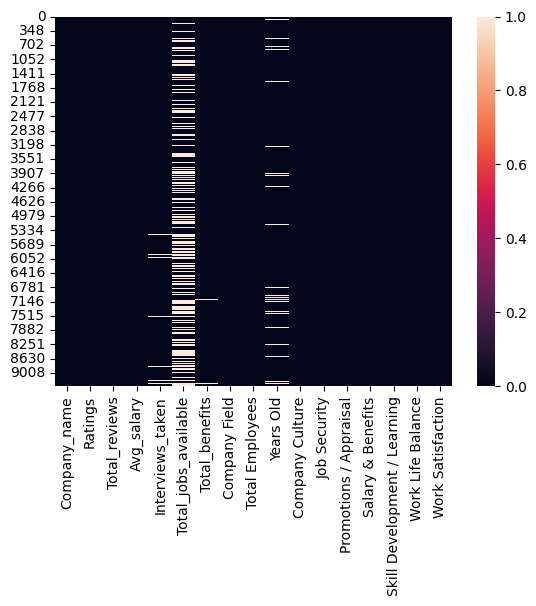

In [99]:
sns.heatmap(final_dataset.isnull())

In [100]:
print(final_dataset.isna().sum())
print(final_dataset.shape)

Company_name                       0
Ratings                            0
Total_reviews                      0
Avg_salary                         0
Interviews_taken                 174
Total_jobs_available            3408
Total_benefits                    49
Company Field                      0
Total Employees                    0
Years Old                        479
Company Culture                    0
Job Security                       0
Promotions / Appraisal             0
Salary & Benefits                  0
Skill Development / Learning       0
Work Life Balance                  0
Work Satisfaction                  0
dtype: int64
(9001, 17)


In [101]:
final_dataset.drop(columns=['Total_jobs_available'], inplace=True)
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9001 entries, 0 to 9354
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Company_name                  9001 non-null   object 
 1   Ratings                       9001 non-null   float64
 2   Total_reviews                 9001 non-null   float64
 3   Avg_salary                    9001 non-null   float64
 4   Interviews_taken              8827 non-null   float64
 5   Total_benefits                8952 non-null   float64
 6   Company Field                 9001 non-null   object 
 7   Total Employees               9001 non-null   object 
 8   Years Old                     8522 non-null   float64
 9   Company Culture               9001 non-null   bool   
 10  Job Security                  9001 non-null   bool   
 11  Promotions / Appraisal        9001 non-null   bool   
 12  Salary & Benefits             9001 non-null   bool   
 13  Skill De

In [102]:
# numerical_data = final_dataset.select_dtypes('float64')
# imputer = KNNImputer(n_neighbors=2, weights='uniform')
# imputer.fit(numerical_data)
# numerical_data = pd.DataFrame(imputer.transform(numerical_data), index = numerical_data.index, columns = numerical_data.columns)
# final_dataset['Years Old'] = numerical_data['Years Old']
# final_dataset['Avg_salary'] = numerical_data['Avg_salary']
# final_dataset['Interviews_taken'] = numerical_data['Interviews_taken']
# final_dataset['Total_benefits'] = numerical_data['Total_benefits']

# final_dataset.info()

In [103]:
filtered_dataset = final_dataset.copy()

In [104]:
filtered_dataset.describe()

,Ratings,Total_reviews,Avg_salary,Interviews_taken,Total_benefits,Years Old
count,9001.000000,9001.000000,9001.000000,8827.000000,8952.000000,8522.000000
mean,3.896478,200658.226864,3946.377647,21778.248556,46168.956658,39.980521
std,0.381832,182492.045475,3852.597730,50110.753864,85552.630833,76.097846
min,1.600000,1000.000000,12.000000,1000.000000,1000.000000,1.000000
25%,3.700000,90000.000000,30.000000,4000.000000,11000.000000,17.000000
50%,3.900000,134000.000000,3900.000000,8000.000000,19000.000000,28.000000
75%,4.100000,246000.000000,7056.000000,18000.000000,42000.000000,45.000000
max,5.000000,999000.000000,11988.000000,972000.000000,973000.000000,2024.000000


<Axes: xlabel='Years Old'>

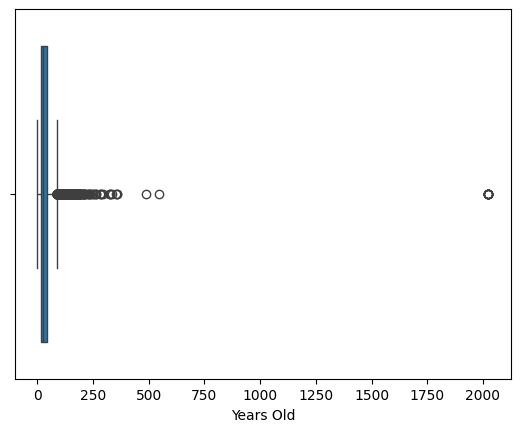

In [105]:
sns.boxplot(filtered_dataset['Years Old'], orient='h')

<Axes: xlabel='Total_benefits'>

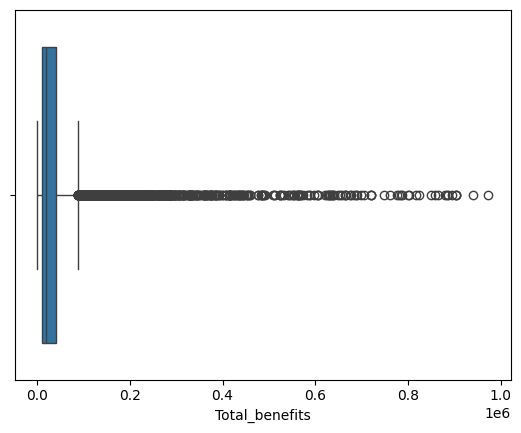

In [106]:
sns.boxplot(filtered_dataset['Total_benefits'], orient='h')

<Axes: xlabel='Interviews_taken'>

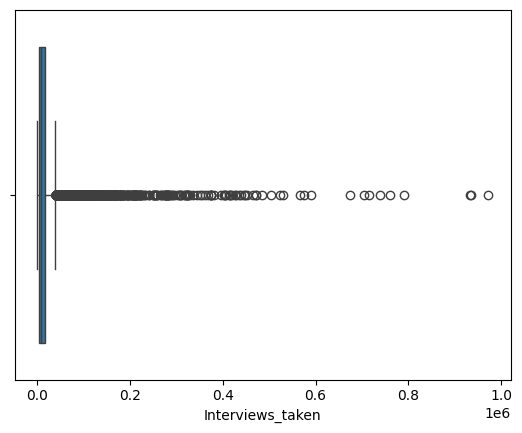

In [107]:
sns.boxplot(filtered_dataset['Interviews_taken'], orient='h')

<Axes: xlabel='Total_reviews'>

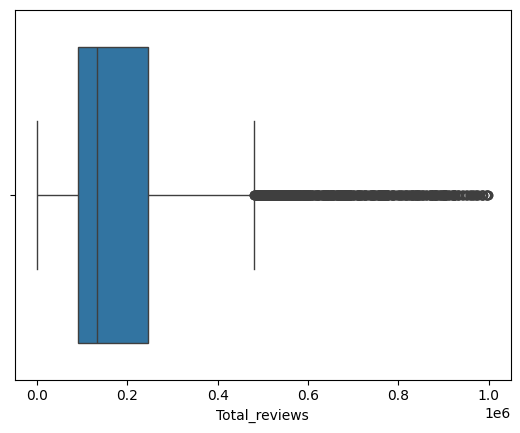

In [108]:
sns.boxplot(filtered_dataset['Total_reviews'], orient='h')

<Axes: xlabel='Ratings'>

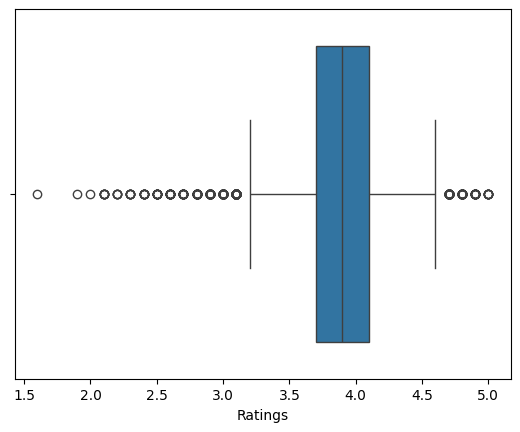

In [109]:
sns.boxplot(filtered_dataset['Ratings'], orient='h')

<Axes: xlabel='Avg_salary'>

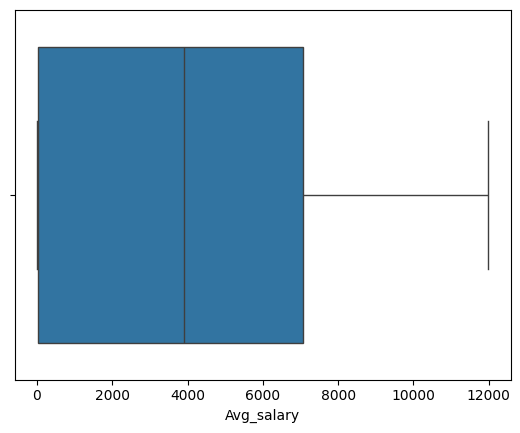

In [110]:
sns.boxplot(filtered_dataset['Avg_salary'], orient='h')

In [111]:
filtered_dataset.reset_index(drop=True, inplace=True)
filtered_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9001 entries, 0 to 9000
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Company_name                  9001 non-null   object 
 1   Ratings                       9001 non-null   float64
 2   Total_reviews                 9001 non-null   float64
 3   Avg_salary                    9001 non-null   float64
 4   Interviews_taken              8827 non-null   float64
 5   Total_benefits                8952 non-null   float64
 6   Company Field                 9001 non-null   object 
 7   Total Employees               9001 non-null   object 
 8   Years Old                     8522 non-null   float64
 9   Company Culture               9001 non-null   bool   
 10  Job Security                  9001 non-null   bool   
 11  Promotions / Appraisal        9001 non-null   bool   
 12  Salary & Benefits             9001 non-null   bool   
 13  Ski

In [112]:
filtered_dataset.describe()

,Ratings,Total_reviews,Avg_salary,Interviews_taken,Total_benefits,Years Old
count,9001.000000,9001.000000,9001.000000,8827.000000,8952.000000,8522.000000
mean,3.896478,200658.226864,3946.377647,21778.248556,46168.956658,39.980521
std,0.381832,182492.045475,3852.597730,50110.753864,85552.630833,76.097846
min,1.600000,1000.000000,12.000000,1000.000000,1000.000000,1.000000
25%,3.700000,90000.000000,30.000000,4000.000000,11000.000000,17.000000
50%,3.900000,134000.000000,3900.000000,8000.000000,19000.000000,28.000000
75%,4.100000,246000.000000,7056.000000,18000.000000,42000.000000,45.000000
max,5.000000,999000.000000,11988.000000,972000.000000,973000.000000,2024.000000


# EDA Analysis

<Axes: xlabel='Ratings', ylabel='Interviews_taken'>

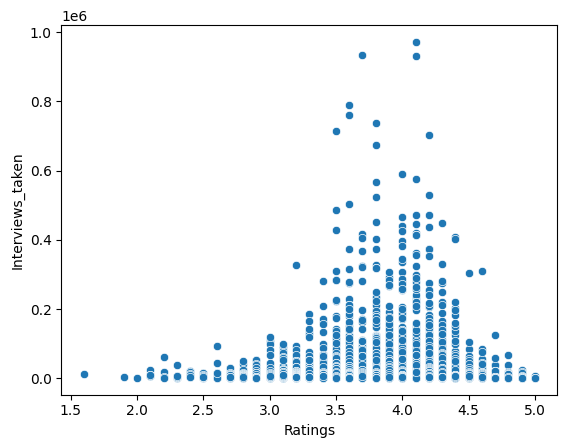

In [113]:
sns.scatterplot(x='Ratings', y='Interviews_taken', data=filtered_dataset)

<Axes: xlabel='Ratings', ylabel='Total_benefits'>

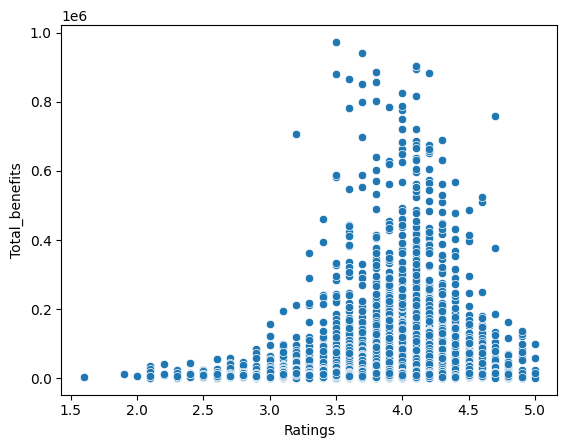

In [114]:
sns.scatterplot(x='Ratings', y='Total_benefits', data=filtered_dataset)

<Axes: xlabel='Ratings', ylabel='Count'>

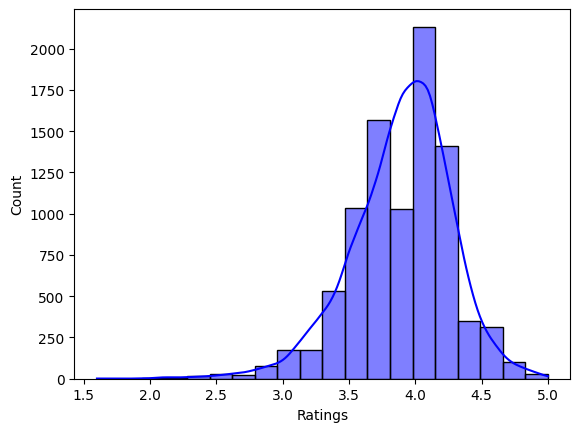

In [115]:
sns.histplot(filtered_dataset['Ratings'], bins=20, kde=True, color='blue')

<Axes: xlabel='Avg_salary', ylabel='Count'>

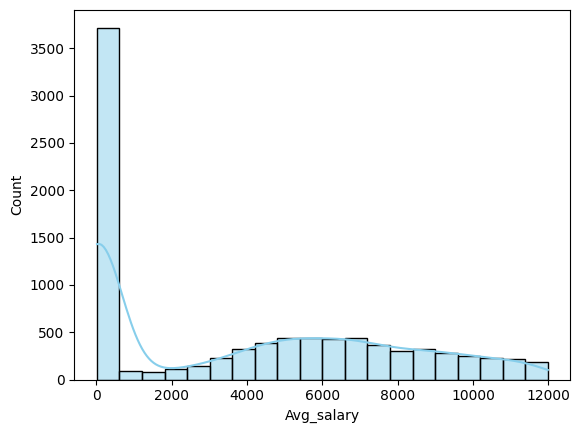

In [116]:
sns.histplot(filtered_dataset['Avg_salary'], bins=20, kde=True, color='skyblue')

<Axes: xlabel='Interviews_taken', ylabel='Count'>

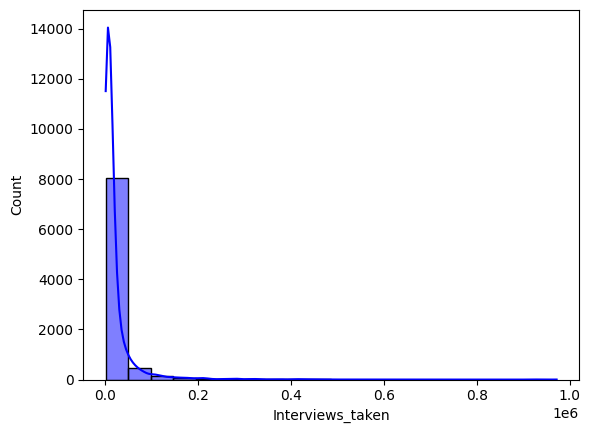

In [117]:
sns.histplot(filtered_dataset['Interviews_taken'], bins=20, kde=True, color='blue')

<Axes: xlabel='Years Old', ylabel='Count'>

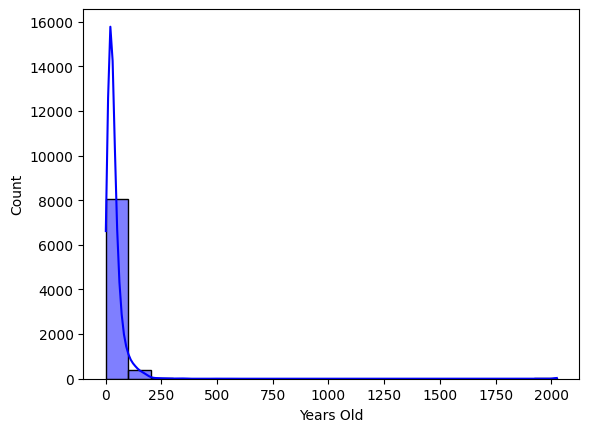

In [118]:
sns.histplot(filtered_dataset['Years Old'], bins=20, kde=True, color='blue')

<Axes: xlabel='Total_benefits', ylabel='Count'>

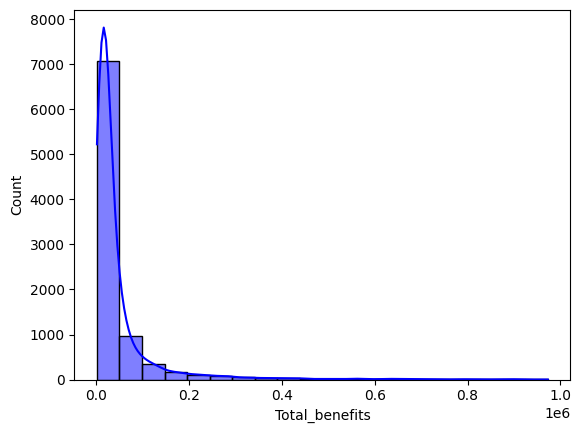

In [119]:
sns.histplot(filtered_dataset['Total_benefits'], bins=20, kde=True, color='blue')

<Axes: xlabel='Total_reviews', ylabel='Count'>

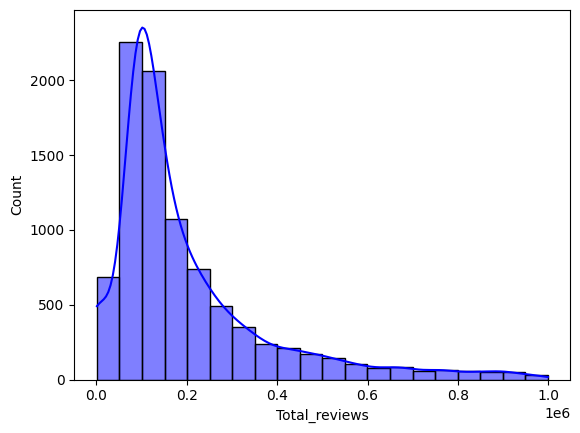

In [120]:
sns.histplot(filtered_dataset['Total_reviews'], bins=20, kde=True, color='blue')

<Axes: >

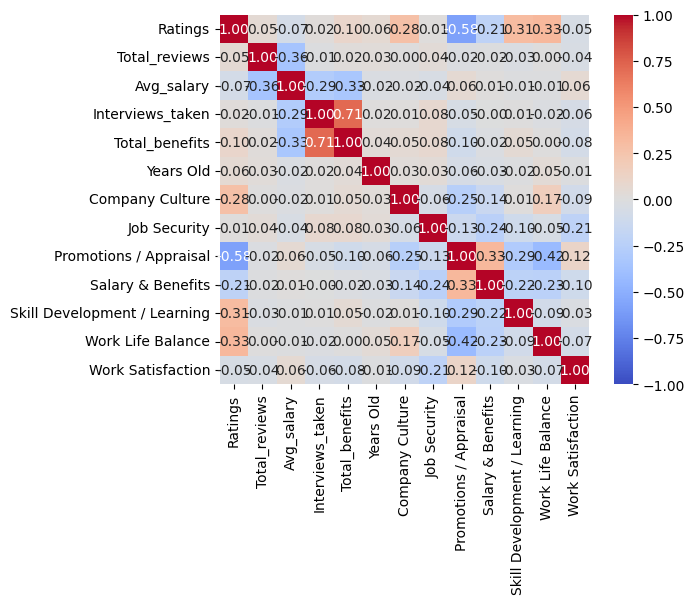

In [121]:
sns.heatmap(filtered_dataset.corr(numeric_only=True), vmin=-1, vmax=1, cmap='coolwarm', annot=True, fmt='.2f', square=True)

In [122]:
filtered_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9001 entries, 0 to 9000
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Company_name                  9001 non-null   object 
 1   Ratings                       9001 non-null   float64
 2   Total_reviews                 9001 non-null   float64
 3   Avg_salary                    9001 non-null   float64
 4   Interviews_taken              8827 non-null   float64
 5   Total_benefits                8952 non-null   float64
 6   Company Field                 9001 non-null   object 
 7   Total Employees               9001 non-null   object 
 8   Years Old                     8522 non-null   float64
 9   Company Culture               9001 non-null   bool   
 10  Job Security                  9001 non-null   bool   
 11  Promotions / Appraisal        9001 non-null   bool   
 12  Salary & Benefits             9001 non-null   bool   
 13  Ski

In [123]:
def top_n_plotter(var_name, N=10):
    df_sorted = filtered_dataset.sort_values(by=var_name, ascending=False)
    y_axis_title = var_name.replace("_", " ").title()
    title = f"Top {N} companies based on " + y_axis_title
    top_N_companies = df_sorted.head(N)
    colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in range(N)]
    fig = go.Figure([go.Bar(x=top_N_companies['Company_name'], y=top_N_companies[var_name], marker_color=colors)])
    fig.update_layout(
        title=title,
        xaxis_title="Company Name",
        yaxis_title=y_axis_title,
        template="plotly_white"
    )
    fig.show()

In [124]:
filtered_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9001 entries, 0 to 9000
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Company_name                  9001 non-null   object 
 1   Ratings                       9001 non-null   float64
 2   Total_reviews                 9001 non-null   float64
 3   Avg_salary                    9001 non-null   float64
 4   Interviews_taken              8827 non-null   float64
 5   Total_benefits                8952 non-null   float64
 6   Company Field                 9001 non-null   object 
 7   Total Employees               9001 non-null   object 
 8   Years Old                     8522 non-null   float64
 9   Company Culture               9001 non-null   bool   
 10  Job Security                  9001 non-null   bool   
 11  Promotions / Appraisal        9001 non-null   bool   
 12  Salary & Benefits             9001 non-null   bool   
 13  Ski

In [125]:
top_n_plotter('Avg_salary', 10)

In [126]:
top_n_plotter('Total_benefits', 10)

In [127]:
top_n_plotter('Ratings', 10)

In [128]:
top_n_plotter('Years Old', 10)

In [129]:
filtered_dataset.corr(numeric_only=True)

,Ratings,Total_reviews,Avg_salary,Interviews_taken,Total_benefits,Years Old,Company Culture,Job Security,Promotions / Appraisal,Salary & Benefits,Skill Development / Learning,Work Life Balance,Work Satisfaction
Ratings,1.000000,0.050514,-0.073400,0.015766,0.099504,0.056889,0.276625,0.011734,-0.583621,-0.214142,0.309064,0.331326,-0.047733
Total_reviews,0.050514,1.000000,-0.355958,-0.008430,0.018202,0.027109,0.000246,0.038662,-0.017175,-0.015090,-0.029757,0.003888,-0.042597
Avg_salary,-0.073400,-0.355958,1.000000,-0.285774,-0.330216,-0.023845,-0.019862,-0.041339,0.059775,0.014232,-0.012230,-0.013163,0.055353
Interviews_taken,0.015766,-0.008430,-0.285774,1.000000,0.712360,0.015341,0.014302,0.075561,-0.051914,-0.004634,0.006288,-0.017307,-0.059124
Total_benefits,0.099504,0.018202,-0.330216,0.712360,1.000000,0.037188,0.047787,0.076475,-0.097631,-0.022044,0.047116,0.000926,-0.075222
Years Old,0.056889,0.027109,-0.023845,0.015341,0.037188,1.000000,0.029461,0.032828,-0.056871,-0.033469,-0.015275,0.046653,-0.011581
Company Culture,0.276625,0.000246,-0.019862,0.014302,0.047787,0.029461,1.000000,-0.061083,-0.253039,-0.142495,0.009903,0.167916,-0.086497
Job Security,0.011734,0.038662,-0.041339,0.075561,0.076475,0.032828,-0.061083,1.000000,-0.132480,-0.235604,-0.102479,-0.054194,-0.214240
Promotions / Appraisal,-0.583621,-0.017175,0.059775,-0.051914,-0.097631,-0.056871,-0.253039,-0.132480,1.000000,0.331008,-0.293587,-0.424376,0.117026
Salary & Benefits,-0.214142,-0.015090,0.014232,-0.004634,-0.022044,-0.033469,-0.142495,-0.235604,0.331008,1.000000,-0.223475,-0.228564,-0.104818


# Standartization and converting continuous variable into categorical

In [130]:
filtered_dataset.drop(columns=['Company_name', 'Work Satisfaction'], inplace=True)
filtered_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9001 entries, 0 to 9000
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ratings                       9001 non-null   float64
 1   Total_reviews                 9001 non-null   float64
 2   Avg_salary                    9001 non-null   float64
 3   Interviews_taken              8827 non-null   float64
 4   Total_benefits                8952 non-null   float64
 5   Company Field                 9001 non-null   object 
 6   Total Employees               9001 non-null   object 
 7   Years Old                     8522 non-null   float64
 8   Company Culture               9001 non-null   bool   
 9   Job Security                  9001 non-null   bool   
 10  Promotions / Appraisal        9001 non-null   bool   
 11  Salary & Benefits             9001 non-null   bool   
 12  Skill Development / Learning  9001 non-null   bool   
 13  Wor

In [131]:
pd.set_option("display.max_rows", None)
filtered_dataset = filtered_dataset[~filtered_dataset['Total Employees'].str.contains('more|years old|Startup|Fortune|Forbes|Hyderabad|Public|State')]
filtered_dataset['Total Employees'] = filtered_dataset['Total Employees'].apply(lambda x: x.replace('1 Lakh+', '100k+'))

In [132]:
filtered_dataset['Total Employees'] = filtered_dataset['Total Employees'].apply(lambda x: x.replace('1 Lakh', '100k'))
filtered_dataset['Total Employees'].value_counts()

Total Employees
1k-5k Employees                 2499
201-500 Employees               1772
501-1k Employees                1695
51-200 Employees                1374
5k-10k Employees                 432
10k-50k Employees                404
11-50 Employees                  225
1k-5k Employees (Global)          91
1-10 Employees                    69
501-1k Employees (Global)         65
201-500 Employees (Global)        58
100k+ Employees                   50
5k-10k Employees (Global)         47
10k-50k Employees (Global)        33
51-200 Employees (Global)         30
50k-100k Employees                29
11-50 Employees (Global)          10
50k-100k Employees (Global)        7
100k+ Employees (Global)           5
1-10 Employees (Global)            3
Name: count, dtype: int64

In [133]:
filtered_dataset.head()

,Ratings,Total_reviews,Avg_salary,Interviews_taken,Total_benefits,Company Field,Total Employees,Years Old,Company Culture,Job Security,Promotions / Appraisal,Salary & Benefits,Skill Development / Learning,Work Life Balance
0,3.8,73100.0,10282.8,6100.0,11500.0,IT Services & Consulting,100k+ Employees,56.0,False,True,False,False,False,True
1,4.0,46400.0,7015.2,4300.0,7100.0,IT Services & Consulting,100k+ Employees,35.0,True,True,False,False,True,False
2,3.9,41700.0,6738.0,3600.0,5800.0,IT Services & Consulting,100k+ Employees,30.0,False,False,False,False,True,False
3,3.8,39200.0,5128.8,3700.0,5000.0,IT Services & Consulting,100k+ Employees,79.0,False,True,False,False,False,False
4,3.9,34000.0,4972.8,2800.0,4000.0,IT Services & Consulting,100k+ Employees,57.0,False,True,False,False,True,True


In [134]:
bins = [0.0, 3.5, 4.0, 5.0]
labels = ['Lowest_Rated_Companies', 'Average_Rated_Companies', 'Higly_Rated_Companies']
filtered_dataset['User_Ratings'] = pd.cut(filtered_dataset['Ratings'], bins=bins, labels=False)
filtered_dataset.drop(columns=['Ratings'], inplace=True)
filtered_dataset['User_Ratings'] = filtered_dataset['User_Ratings'].astype(float)

In [135]:
filtered_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8898 entries, 0 to 9000
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Total_reviews                 8898 non-null   float64
 1   Avg_salary                    8898 non-null   float64
 2   Interviews_taken              8730 non-null   float64
 3   Total_benefits                8851 non-null   float64
 4   Company Field                 8898 non-null   object 
 5   Total Employees               8898 non-null   object 
 6   Years Old                     8474 non-null   float64
 7   Company Culture               8898 non-null   bool   
 8   Job Security                  8898 non-null   bool   
 9   Promotions / Appraisal        8898 non-null   bool   
 10  Salary & Benefits             8898 non-null   bool   
 11  Skill Development / Learning  8898 non-null   bool   
 12  Work Life Balance             8898 non-null   bool   
 13  User_Rat

In [136]:
filtered_dataset['Company Field'].astype('category')

0                               IT Services & Consulting 
1                               IT Services & Consulting 
2                               IT Services & Consulting 
3                               IT Services & Consulting 
4                               IT Services & Consulting 
5                                                Banking 
6                                                Banking 
7                               IT Services & Consulting 
8                               IT Services & Consulting 
9                               IT Services & Consulting 
10                              IT Services & Consulting 
11                                               Banking 
12                                                   BPO 
13                                                   BPO 
14                                               Telecom 
15                                              Internet 
16                              IT Services & Consulting 
17            

In [137]:
filtered_dataset['Total Employees'].astype('category')

0                    100k+ Employees 
1                    100k+ Employees 
2                    100k+ Employees 
3                    100k+ Employees 
4                    100k+ Employees 
5                    100k+ Employees 
6                    100k+ Employees 
7                    100k+ Employees 
8                    100k+ Employees 
9                    100k+ Employees 
10                   100k+ Employees 
11                50k-100k Employees 
12                50k-100k Employees 
13                50k-100k Employees 
14                50k-100k Employees 
15                   100k+ Employees 
16                   100k+ Employees 
17                   100k+ Employees 
18                   100k+ Employees 
19                 10k-50k Employees 
20                  5k-10k Employees 
21                 10k-50k Employees 
22                50k-100k Employees 
23                   100k+ Employees 
24                   100k+ Employees 
25                 10k-50k Employees 
26          

In [138]:
numerical_features = ['Total_reviews', 'Avg_salary', 'Years Old', 'Interviews_taken', 'Total_benefits']
categorical_features = ['Company Field', 'Total Employees']

<Axes: xlabel='User_Ratings'>

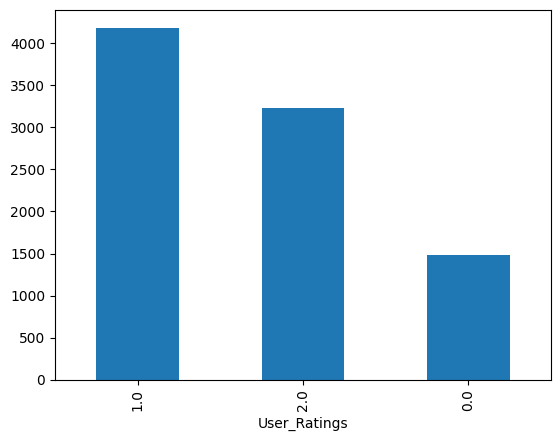

In [139]:
filtered_dataset['User_Ratings'].value_counts().plot(kind='bar')

In [140]:
# filtered_dataset.drop(columns=['Total Employees', 'Company Field'], inplace=True)

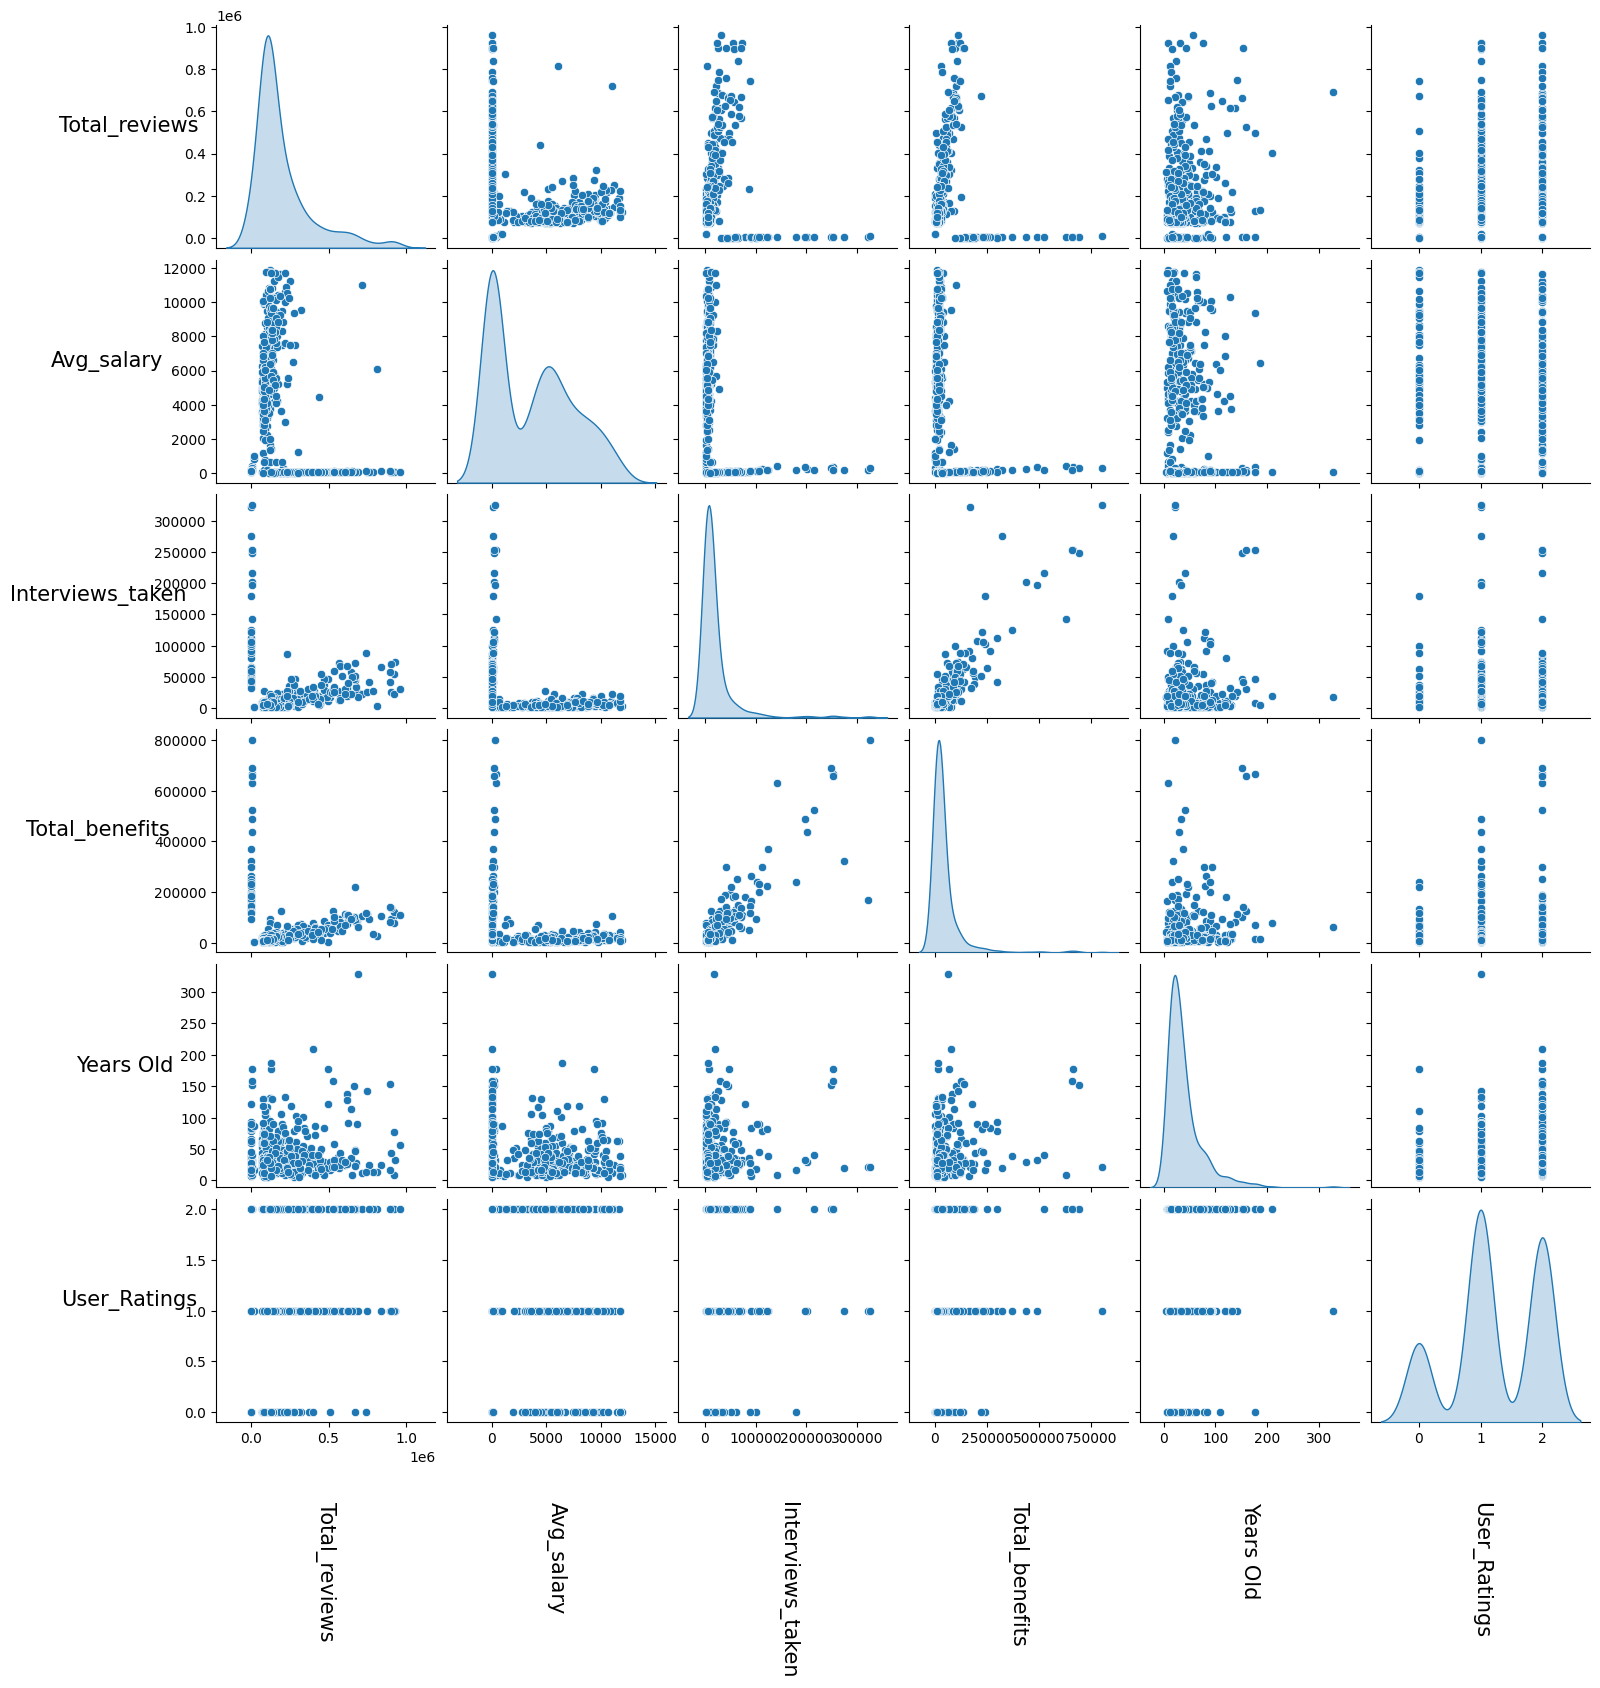

In [141]:
np.random.seed(42) # для повторяемости эксперимента
df_numeric = filtered_dataset.select_dtypes('float64')
rand_data = np.random.choice(np.arange(df_numeric.shape[0]), size=500, replace=False)
g = sns.pairplot(df_numeric.iloc[rand_data], diag_kind='kde')
for ax in g.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation=-90, fontsize=15, labelpad=40)
    ax.set_ylabel(ax.get_ylabel(), rotation=0, fontsize=15, labelpad=40)

In [142]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import StratifiedKFold
y = filtered_dataset['User_Ratings']
x = filtered_dataset.drop('User_Ratings', axis=1)
k_fold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
scaler = StandardScaler()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
cols = x_train.columns

In [143]:
x_train.drop(columns=['Avg_salary'], inplace=True)
x_test.drop(columns=['Avg_salary'], inplace=True)

In [144]:
x_train.head()

,Total_reviews,Interviews_taken,Total_benefits,Company Field,Total Employees,Years Old,Company Culture,Job Security,Promotions / Appraisal,Salary & Benefits,Skill Development / Learning,Work Life Balance
1957,362000.0,22000.0,61000.0,Healthcare,5k-10k Employees,57.0,False,False,False,False,False,True
8983,72000.0,7000.0,2000.0,Iron & Steel,1k-5k Employees,29.0,False,True,False,False,True,False
351,1700.0,93000.0,218000.0,Retail,5k-10k Employees,22.0,True,True,False,False,True,False
1516,468000.0,25000.0,55000.0,Industrial Machinery,1k-5k Employees,99.0,True,True,False,False,True,False
3540,204000.0,10000.0,23000.0,Engineering & Construction,1k-5k Employees,41.0,True,True,True,False,False,False


In [145]:
def deal_with_outliners(series, x_train, x_test):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    q1_bound = Q1 - 1.5 * IQR
    q2_bound = Q3 + 1.5 * IQR
    x_train[series.name] = np.where(
        x_train[series.name] > q2_bound,
        q2_bound,
        np.where(
            x_train[series.name] < q1_bound,
            q1_bound,
            x_train[series.name]
        )  
    )
    x_test[series.name] = np.where(
        x_test[series.name] > q2_bound,
        q2_bound,
        np.where(
            x_test[series.name] < q1_bound,
            q1_bound,
            x_test[series.name]
        )  
    )
    return x_train, x_test

columns_with_outliners = ['Total_reviews', 'Total_benefits', 'Interviews_taken', 'Years Old'] # one or more
for col in columns_with_outliners:
    x_train, x_test = deal_with_outliners(x_train[col], x_train, x_test)

In [146]:
x_train.head()

,Total_reviews,Interviews_taken,Total_benefits,Company Field,Total Employees,Years Old,Company Culture,Job Security,Promotions / Appraisal,Salary & Benefits,Skill Development / Learning,Work Life Balance
1957,362000.0,22000.0,61000.0,Healthcare,5k-10k Employees,57.0,False,False,False,False,False,True
8983,72000.0,7000.0,2000.0,Iron & Steel,1k-5k Employees,29.0,False,True,False,False,True,False
351,1700.0,39000.0,88500.0,Retail,5k-10k Employees,22.0,True,True,False,False,True,False
1516,468000.0,25000.0,55000.0,Industrial Machinery,1k-5k Employees,87.0,True,True,False,False,True,False
3540,204000.0,10000.0,23000.0,Engineering & Construction,1k-5k Employees,41.0,True,True,True,False,False,False


In [147]:
x_train.isna().sum()

Total_reviews                     0
Interviews_taken                128
Total_benefits                   30
Company Field                     0
Total Employees                   0
Years Old                       310
Company Culture                   0
Job Security                      0
Promotions / Appraisal            0
Salary & Benefits                 0
Skill Development / Learning      0
Work Life Balance                 0
dtype: int64

In [148]:
x_test.isna().sum()

Total_reviews                     0
Interviews_taken                 40
Total_benefits                   17
Company Field                     0
Total Employees                   0
Years Old                       114
Company Culture                   0
Job Security                      0
Promotions / Appraisal            0
Salary & Benefits                 0
Skill Development / Learning      0
Work Life Balance                 0
dtype: int64

In [149]:
numerical_features = ['Total_reviews', 'Years Old', 'Interviews_taken', 'Total_benefits']

In [150]:
x_train[numerical_features] = scaler.fit_transform(x_train[numerical_features])
x_test[numerical_features] = scaler.transform(x_test[numerical_features])

In [151]:
x_train.head()

,Total_reviews,Interviews_taken,Total_benefits,Company Field,Total Employees,Years Old,Company Culture,Job Security,Promotions / Appraisal,Salary & Benefits,Skill Development / Learning,Work Life Balance
1957,1.312710,0.706787,1.118788,Healthcare,5k-10k Employees,0.989982,False,False,False,False,False,True
8983,-0.836063,-0.527694,-1.080859,Iron & Steel,1k-5k Employees,-0.232445,False,True,False,False,True,False
351,-1.356956,2.105865,2.144047,Retail,5k-10k Employees,-0.538052,True,True,False,False,True,False
1516,2.098124,0.953683,0.895095,Industrial Machinery,1k-5k Employees,2.299725,True,True,False,False,True,False
3540,0.141999,-0.280798,-0.297934,Engineering & Construction,1k-5k Employees,0.291452,True,True,True,False,False,False


In [152]:
imputer = KNNImputer(n_neighbors=5, weights='uniform')
imputer.fit(x_train[numerical_features])
x_train[numerical_features] = imputer.transform(x_train[numerical_features])
x_test[numerical_features] = imputer.transform(x_test[numerical_features])

In [153]:
x_train.isna().sum()

Total_reviews                   0
Interviews_taken                0
Total_benefits                  0
Company Field                   0
Total Employees                 0
Years Old                       0
Company Culture                 0
Job Security                    0
Promotions / Appraisal          0
Salary & Benefits               0
Skill Development / Learning    0
Work Life Balance               0
dtype: int64

In [154]:
x_test.isna().sum()

Total_reviews                   0
Interviews_taken                0
Total_benefits                  0
Company Field                   0
Total Employees                 0
Years Old                       0
Company Culture                 0
Job Security                    0
Promotions / Appraisal          0
Salary & Benefits               0
Skill Development / Learning    0
Work Life Balance               0
dtype: int64

In [155]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
transformer = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), ['Company Field', 'Total Employees']))

In [156]:
transformed = transformer.fit_transform(x_train).toarray()
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
transformed_df.index = x_train.index
x_train = pd.concat([x_train, transformed_df], axis=1)
x_train.drop(categorical_features, axis=1, inplace=True)
x_train.head()

,Total_reviews,Interviews_taken,Total_benefits,Years Old,Company Culture,Job Security,Promotions / Appraisal,Salary & Benefits,Skill Development / Learning,Work Life Balance,...,onehotencoder__Total Employees_ 201-500 Employees,onehotencoder__Total Employees_ 201-500 Employees (Global),onehotencoder__Total Employees_ 501-1k Employees,onehotencoder__Total Employees_ 501-1k Employees (Global),onehotencoder__Total Employees_ 50k-100k Employees,onehotencoder__Total Employees_ 50k-100k Employees (Global),onehotencoder__Total Employees_ 51-200 Employees,onehotencoder__Total Employees_ 51-200 Employees (Global),onehotencoder__Total Employees_ 5k-10k Employees,onehotencoder__Total Employees_ 5k-10k Employees (Global)
1957,1.312710,0.706787,1.118788,0.989982,False,False,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8983,-0.836063,-0.527694,-1.080859,-0.232445,False,True,False,False,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
351,-1.356956,2.105865,2.144047,-0.538052,True,True,False,False,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1516,2.098124,0.953683,0.895095,2.299725,True,True,False,False,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3540,0.141999,-0.280798,-0.297934,0.291452,True,True,True,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [157]:
transformed = transformer.transform(x_test).toarray()
transformed_df = pd.DataFrame(transformed, columns = transformer.get_feature_names_out())
transformed_df.index = x_test.index
x_test = pd.concat([x_test, transformed_df], axis=1)
x_test.drop(categorical_features, axis=1, inplace=True)
x_test.head()

,Total_reviews,Interviews_taken,Total_benefits,Years Old,Company Culture,Job Security,Promotions / Appraisal,Salary & Benefits,Skill Development / Learning,Work Life Balance,...,onehotencoder__Total Employees_ 201-500 Employees,onehotencoder__Total Employees_ 201-500 Employees (Global),onehotencoder__Total Employees_ 501-1k Employees,onehotencoder__Total Employees_ 501-1k Employees (Global),onehotencoder__Total Employees_ 50k-100k Employees,onehotencoder__Total Employees_ 50k-100k Employees (Global),onehotencoder__Total Employees_ 51-200 Employees,onehotencoder__Total Employees_ 51-200 Employees (Global),onehotencoder__Total Employees_ 5k-10k Employees,onehotencoder__Total Employees_ 5k-10k Employees (Global)
4696,-0.258117,-0.280798,-0.633473,0.902665,False,False,False,True,True,False,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2032,1.216386,0.624488,0.932377,0.597059,True,True,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8649,-0.806425,-0.939187,-1.043577,-1.192924,True,True,False,False,True,False,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8936,-0.828654,-0.972107,-0.790058,0.745496,True,True,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8167,-0.769377,-0.774590,-0.819884,-0.843659,True,False,True,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [158]:
x_train, y_train = resample.fit_resample(x_train, y_train)

# Метод k ближайших соседей

In [159]:
train_scores = []
test_scores = []
for k in range(1, 63, 2):
    print(f'Обработка k = {k}')
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    report = metrics.classification_report(y_test, y_pred, target_names=labels)
    print(report)
    print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, y_pred)))
    print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))
    train_scores.append(model.score(x_train, y_train))
    test_scores.append(model.score(x_test, y_test))
print('Обработка завершена')


Обработка k = 1
                         precision    recall  f1-score   support

 Lowest_Rated_Companies       0.42      0.54      0.47       371
Average_Rated_Companies       0.59      0.51      0.55      1036
  Higly_Rated_Companies       0.63      0.65      0.64       818

               accuracy                           0.57      2225
              macro avg       0.55      0.57      0.55      2225
           weighted avg       0.57      0.57      0.57      2225

accuracy: 0.567
Confusion matrix:
 [[199 135  37]
 [227 531 278]
 [ 46 240 532]]
Обработка k = 3
                         precision    recall  f1-score   support

 Lowest_Rated_Companies       0.39      0.68      0.50       371
Average_Rated_Companies       0.62      0.42      0.50      1036
  Higly_Rated_Companies       0.64      0.69      0.67       818

               accuracy                           0.56      2225
              macro avg       0.55      0.60      0.56      2225
           weighted avg       0.59   

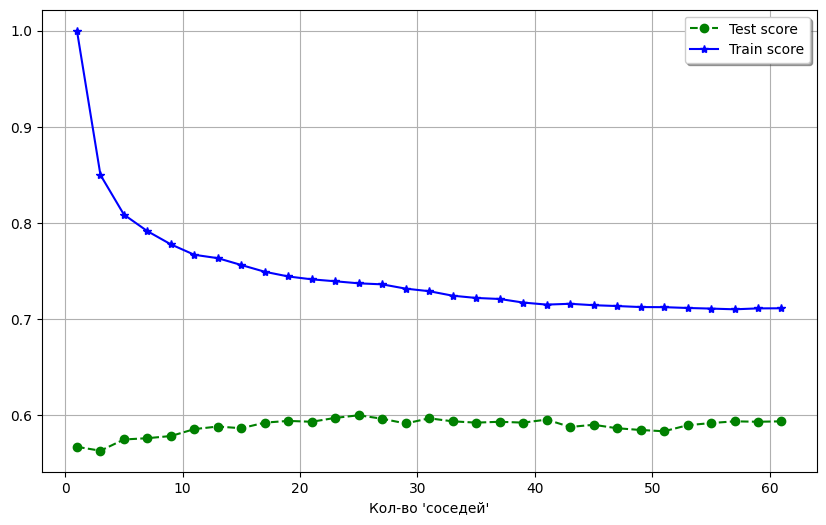

In [160]:
x_data = np.arange(1, 63, 2)
plt.figure(figsize=(10, 6))
plt.plot(x_data, test_scores, label='Test score', color='green', marker='o', linestyle='dashed')
plt.plot(x_data, train_scores, label='Train score', color='blue', marker='*')
plt.grid()
plt.xlabel("Кол-во 'соседей'")
plt.legend(shadow=True, loc='best')
pass

In [161]:
c = 0
print('Коэффициент детерминации при k =')
for i in range(1, 63, 2):
    print(f' {i} на тестовой выборке: {test_scores[c]} \t на тренировочной выборке: {train_scores[c]}')
    c+=1

Коэффициент детерминации при k =
 1 на тестовой выборке: 0.5671910112359551 	 на тренировочной выборке: 0.9998936509624587
 3 на тестовой выборке: 0.5631460674157304 	 на тренировочной выборке: 0.8499415080293523
 5 на тестовой выборке: 0.5748314606741574 	 на тренировочной выборке: 0.8086780814633627
 7 на тестовой выборке: 0.5761797752808989 	 на тренировочной выборке: 0.7914495373816867
 9 на тестовой выборке: 0.5784269662921349 	 на тренировочной выборке: 0.7777305115388706
 11 на тестовой выборке: 0.5856179775280899 	 на тренировочной выборке: 0.7668829097096671
 13 на тестовой выборке: 0.588314606741573 	 на тренировочной выборке: 0.7633733914708072
 15 на тестовой выборке: 0.5865168539325842 	 на тренировочной выборке: 0.7562480059555461
 17 на тестовой выборке: 0.5923595505617978 	 на тренировочной выборке: 0.7492289694778262
 19 на тестовой выборке: 0.5941573033707865 	 на тренировочной выборке: 0.7443369137509306
 21 на тестовой выборке: 0.5932584269662922 	 на тренировочной 

In [162]:
knn = KNeighborsClassifier()
param_grid_knn = { 
    'n_neighbors': (1,64, 2),
    'leaf_size': (20,40,1),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev'),
}
CV_rfc = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=k_fold, scoring='f1_macro', n_jobs = -1)
CV_rfc.fit(x_train, y_train)
CV_rfc.best_params_

{'leaf_size': 20,
 'metric': 'minkowski',
 'n_neighbors': 1,
 'p': 1,
 'weights': 'uniform'}

                         precision    recall  f1-score   support

 Lowest_Rated_Companies       0.44      0.48      0.46       371
Average_Rated_Companies       0.58      0.56      0.57      1036
  Higly_Rated_Companies       0.63      0.64      0.64       818

               accuracy                           0.58      2225
              macro avg       0.55      0.56      0.55      2225
           weighted avg       0.58      0.58      0.58      2225

accuracy: 0.576


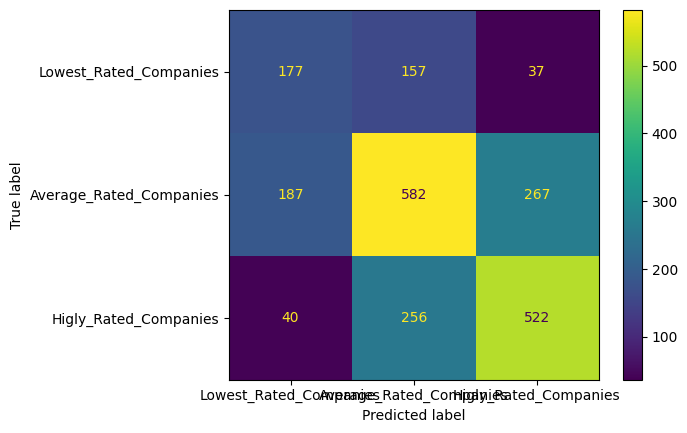

In [163]:
model = KNeighborsClassifier(n_neighbors=1, leaf_size=20, metric='minkowski', p=1, weights='uniform')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
report = metrics.classification_report(y_test, y_pred, target_names=labels)
print(report)
print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, y_pred)))
cm = confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

# Логистическая регрессия

In [164]:
lg = LogisticRegression(random_state=42)
param_grid_lg = { 
    "C" : np.logspace(-3,3,7),
    "penalty" : ["l1", "l2"],
    "multi_class" : ['multinomial'],
    "max_iter" : [200],
    "solver" : ['lbfgs', 'newton-cg']
}
CV_rfc = GridSearchCV(estimator=lg, param_grid=param_grid_lg, cv=k_fold, scoring='f1_macro', n_jobs=-1)
CV_rfc.fit(x_train, y_train)
CV_rfc.best_params_

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


28 fits failed out of a total of 56.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\AppData\L

{'C': 1.0,
 'max_iter': 200,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'solver': 'newton-cg'}

                         precision    recall  f1-score   support

 Lowest_Rated_Companies       0.51      0.71      0.59       371
Average_Rated_Companies       0.70      0.51      0.59      1036
  Higly_Rated_Companies       0.69      0.81      0.74       818

               accuracy                           0.65      2225
              macro avg       0.63      0.67      0.64      2225
           weighted avg       0.66      0.65      0.65      2225

accuracy: 0.651
f1_score: 0.642


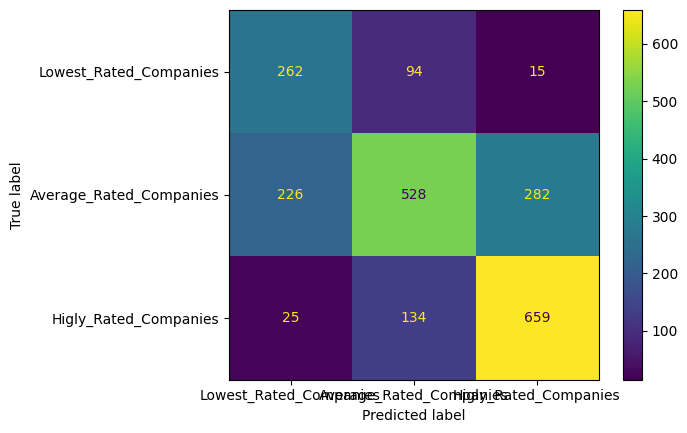

In [165]:
model = LogisticRegression(random_state=42, multi_class='multinomial', C=1.0, max_iter=200, penalty='l2', solver='newton-cg')
model.fit(x_train, y_train)
pred = model.predict(x_test)
report = metrics.classification_report(y_test, pred, target_names=labels)
print(report)
print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, pred)))
print("f1_score: {:0.3f}".format(metrics.f1_score(y_test, pred, average='macro')))
cm = confusion_matrix(y_test, pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

# Random Forest

In [166]:
rfc = RandomForestClassifier(random_state=42)
param_grid_rf = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid_rf, cv=k_fold, scoring='f1_macro', n_jobs=-1)
CV_rfc.fit(x_train, y_train)
CV_rfc.best_params_

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", 

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 200}

                         precision    recall  f1-score   support

 Lowest_Rated_Companies       0.49      0.80      0.61       371
Average_Rated_Companies       0.79      0.38      0.51      1036
  Higly_Rated_Companies       0.65      0.90      0.76       818

               accuracy                           0.64      2225
              macro avg       0.65      0.69      0.63      2225
           weighted avg       0.69      0.64      0.62      2225

accuracy: 0.640
f1_score: 0.625


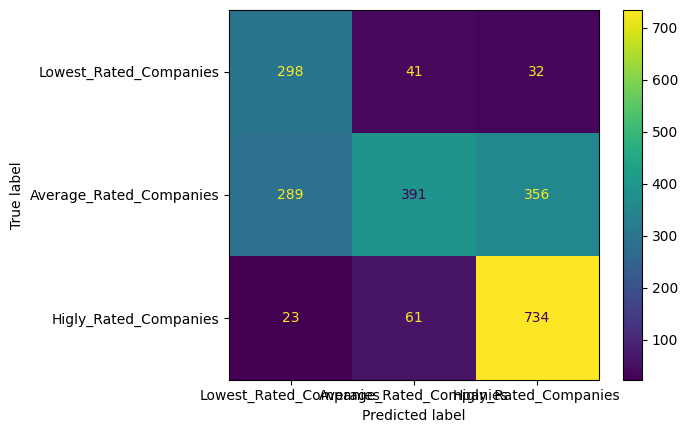

In [167]:
model = RandomForestClassifier(random_state=42, criterion='gini', max_depth=8, max_features='sqrt', n_estimators=500)
model.fit(x_train, y_train)
pred = model.predict(x_test)
report = metrics.classification_report(y_test, pred, target_names=labels)
print(report)
print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, pred)))
print("f1_score: {:0.3f}".format(metrics.f1_score(y_test, pred, average='macro')))
cm = confusion_matrix(y_test, pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)                       
disp.plot()

In [168]:
from sklearn.feature_selection import RFECV
def get_best_feature_and_hyperparameters_for_model(model, param_grid, x_train, y_train):
    rfecv = RFECV(estimator=model, step=1, cv=k_fold, scoring='f1_macro', verbose=10,n_jobs = -1)
    grid_search = GridSearchCV(estimator=rfecv, param_grid=param_grid, cv=k_fold, verbose=10,scoring='f1_macro', n_jobs=-1)
    grid_search.fit(x_train, y_train)
    print(f'Tuned hyperparameters: \n')
    print(f'{grid_search.best_params_}')
    print()
    
    best_grid_search = grid_search.best_estimator_
    print(f'Best Estimator: \n')
    print(f'{best_grid_search}')
  
    return best_grid_search
    

In [169]:
param_grid_rf = { 
    'estimator__n_estimators': [200, 500],
    'estimator__max_features': ['auto', 'sqrt'],
    'estimator__max_depth' : [6,7,8],
    'estimator__criterion' :['gini', 'entropy']
}
param_grid_lg = { 
    "estimator__C" : np.logspace(-3,3,7),
    "estimator__penalty" : ["l1", "l2"],
    "estimator__multi_class" : ['multinomial'],
    "estimator__max_iter" : [200],
    "estimator__solver" : ['lbfgs', 'newton-cg']
}

In [170]:
rf = RandomForestClassifier(random_state=42)
lg = LogisticRegression(random_state=42)

In [171]:
lg_rfecv = get_best_feature_and_hyperparameters_for_model(lg, param_grid_lg, x_train, y_train)
pred = lg_rfecv.predict(x_test)
report = metrics.classification_report(y_test, pred, target_names=labels)
print(report)

Fitting 2 folds for each of 28 candidates, totalling 56 fits


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


28 fits failed out of a total of 56.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_parallel_backends.py", line 273, in _wrap_func_call
    return func()
           ^^^^^^
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\parallel.py", line 589, in __call__
    return [func(*args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User

Fitting estimator with 113 features.
Tuned hyperparameters: 

{'estimator__C': 100.0, 'estimator__max_iter': 200, 'estimator__multi_class': 'multinomial', 'estimator__penalty': 'l2', 'estimator__solver': 'newton-cg'}

Best Estimator: 

RFECV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
      estimator=LogisticRegression(C=100.0, max_iter=200,
                                   multi_class='multinomial', random_state=42,
                                   solver='newton-cg'),
      n_jobs=-1, scoring='f1_macro', verbose=10)
                         precision    recall  f1-score   support

 Lowest_Rated_Companies       0.51      0.71      0.59       371
Average_Rated_Companies       0.70      0.51      0.59      1036
  Higly_Rated_Companies       0.69      0.80      0.74       818

               accuracy                           0.65      2225
              macro avg       0.63      0.67      0.64      2225
           weighted avg       0.66      0.65      0.65      2

In [172]:
print("Finished feature selection and parameter tuning")
print("Optimal number of features : %d" % lg_rfecv.n_features_)
features = pd.DataFrame(x_train.columns[lg_rfecv.support_], columns=['Features'])
print(features)

Finished feature selection and parameter tuning
Optimal number of features : 112
                                              Features
0                                        Total_reviews
1                                     Interviews_taken
2                                       Total_benefits
3                                            Years Old
4                                      Company Culture
5                                         Job Security
6                               Promotions / Appraisal
7                                    Salary & Benefits
8                         Skill Development / Learning
9                                    Work Life Balance
10   onehotencoder__Company Field_Accounting & Audi...
11           onehotencoder__Company Field_Agriculture 
12        onehotencoder__Company Field_Agro Chemicals 
13       onehotencoder__Company Field_Analytics & KPO 
14       onehotencoder__Company Field_Animation & VFX 
15   onehotencoder__Company Field_Archi

In [173]:
print(metrics.f1_score(y_test, pred, average='macro'))

0.6406240080634963


 # Logistic Regression after RFECV
    Lowest_Rated_Companies       0.50      0.70      0.58       371
    Average_Rated_Companies       0.69      0.51      0.58      1036
    Higly_Rated_Companies       0.69      0.80      0.74       818

               accuracy                           0.65      2225
              macro avg       0.63      0.67      0.64      2225
           weighted avg       0.66      0.65      0.64      2225

# Logistic Regression without RFECV
                         precision    recall  f1-score   support

    Lowest_Rated_Companies       0.51      0.70      0.59       371
    Average_Rated_Companies       0.69      0.51      0.59      1036
    Higly_Rated_Companies       0.69      0.80      0.74       818

               accuracy                           0.65      2225
              macro avg       0.63      0.67      0.64      2225
           weighted avg       0.66      0.65      0.64      2225

In [175]:
rfc_rfecv = get_best_feature_and_hyperparameters_for_model(rfc, param_grid_rf, x_train, y_train)
pred = rfc_rfecv.predict(x_test)
report = metrics.classification_report(y_test, pred, target_names=labels)
print(report)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


36 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_parallel_backends.py", line 273, in _wrap_func_call
    return func()
           ^^^^^^
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\parallel.py", line 589, in __call__
    return [func(*args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\

Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estima

 # Random Forest Classifier after RFECV
    Lowest_Rated_Companies       0.48      0.79      0.60       371
    Average_Rated_Companies       0.74      0.43      0.54      1036
    Higly_Rated_Companies       0.68      0.85      0.76       818

               accuracy                           0.64      2225
              macro avg       0.64      0.69      0.63      2225
           weighted avg       0.68      0.64      0.63      2225


# Random Forest Classifier without RFECV
     Lowest_Rated_Companies       0.48      0.79      0.60       371
     Average_Rated_Companies       0.79      0.39      0.52      1036
     Higly_Rated_Companies       0.66      0.90      0.76       818

               accuracy                           0.64      2225
              macro avg       0.64      0.69      0.63      2225
           weighted avg       0.69      0.64      0.62      2225

In [176]:
print(metrics.f1_score(y_test, pred, average='macro'))

0.634293486149706


In [177]:
print("Finished feature selection and parameter tuning")

print("Optimal number of features : %d" % rfc_rfecv.n_features_)
features_rfc = pd.DataFrame(x_train.columns[rfc_rfecv.support_])
print(features_rfc)

Finished feature selection and parameter tuning
Optimal number of features : 11
                                                    0
0                                       Total_reviews
1                                    Interviews_taken
2                                      Total_benefits
3                                           Years Old
4                                     Company Culture
5                                        Job Security
6                              Promotions / Appraisal
7                                   Salary & Benefits
8                        Skill Development / Learning
9                                   Work Life Balance
10  onehotencoder__Company Field_IT Services & Con...


In [178]:
optimal_features = [f for f,s in zip(x_train.columns, rfc_rfecv.support_) if s]

In [198]:
print(x_train.shape)

(9403, 113)


In [199]:
x_train_optimal_features = x_train[optimal_features]
x_test_optimal_features =  x_test[optimal_features]
print(x_train_optimal_features.shape)
print(x_test_optimal_features.shape)

(9403, 11)
(2225, 11)


# Rerun with optimal features

## KNeighborsClassifier

In [201]:
train_scores = []
test_scores = []
for k in range(1, 63, 2):
    print(f'Обработка k = {k}')
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(x_train_optimal_features, y_train)
    y_pred = model.predict(x_test_optimal_features)
    report = metrics.classification_report(y_test, y_pred, target_names=labels)
    print(report)
    print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, y_pred)))
    print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))
    train_scores.append(model.score(x_train_optimal_features, y_train))
    test_scores.append(model.score(x_test_optimal_features, y_test))
print('Обработка завершена')


Обработка k = 1
                         precision    recall  f1-score   support

 Lowest_Rated_Companies       0.47      0.56      0.51       371
Average_Rated_Companies       0.60      0.57      0.58      1036
  Higly_Rated_Companies       0.65      0.65      0.65       818

               accuracy                           0.59      2225
              macro avg       0.58      0.59      0.58      2225
           weighted avg       0.60      0.59      0.60      2225

accuracy: 0.594
Confusion matrix:
 [[206 139  26]
 [196 586 254]
 [ 33 255 530]]
Обработка k = 3
                         precision    recall  f1-score   support

 Lowest_Rated_Companies       0.44      0.64      0.52       371
Average_Rated_Companies       0.63      0.51      0.56      1036
  Higly_Rated_Companies       0.67      0.69      0.68       818

               accuracy                           0.60      2225
              macro avg       0.58      0.62      0.59      2225
           weighted avg       0.61   

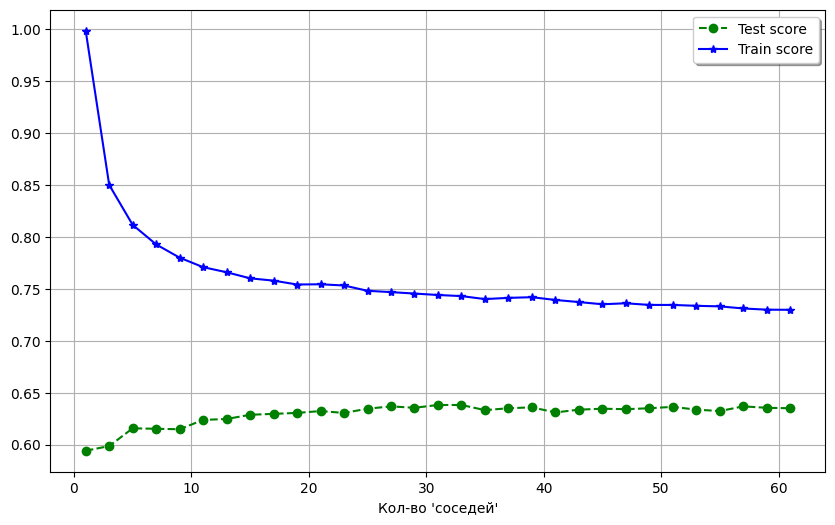

In [202]:
x_data = np.arange(1, 63, 2)
plt.figure(figsize=(10, 6))
plt.plot(x_data, test_scores, label='Test score', color='green', marker='o', linestyle='dashed')
plt.plot(x_data, train_scores, label='Train score', color='blue', marker='*')
plt.grid()
plt.xlabel("Кол-во 'соседей'")
plt.legend(shadow=True, loc='best')
pass

In [203]:
knn = KNeighborsClassifier()
param_grid_knn = { 
    'n_neighbors': (1,64, 2),
    'leaf_size': (20,40,1),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev'),
}
CV_rfc = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=k_fold, scoring='f1_macro', n_jobs = -1)
CV_rfc.fit(x_train_optimal_features, y_train)
CV_rfc.best_params_

{'leaf_size': 20,
 'metric': 'minkowski',
 'n_neighbors': 64,
 'p': 1,
 'weights': 'distance'}

                         precision    recall  f1-score   support

 Lowest_Rated_Companies       0.49      0.73      0.59       371
Average_Rated_Companies       0.72      0.46      0.56      1036
  Higly_Rated_Companies       0.67      0.83      0.74       818

               accuracy                           0.64      2225
              macro avg       0.63      0.67      0.63      2225
           weighted avg       0.67      0.64      0.63      2225

accuracy: 0.642


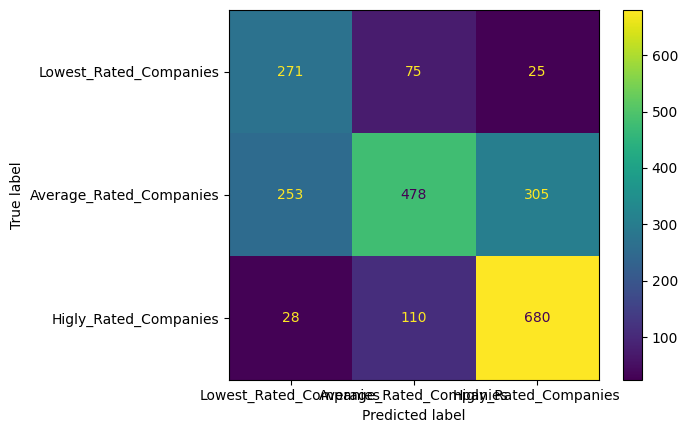

In [204]:
model = KNeighborsClassifier(n_neighbors=64, leaf_size=20, metric='minkowski', p=1, weights='distance')
model.fit(x_train_optimal_features, y_train)
y_pred = model.predict(x_test_optimal_features)
report = metrics.classification_report(y_test, y_pred, target_names=labels)
print(report)
print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, y_pred)))
cm = confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

## Logistic Regression

In [185]:
lg = LogisticRegression(random_state=42)
param_grid_lg = { 
    "C" : np.logspace(-3,3,7),
    "penalty" : ["l1", "l2"],
    "multi_class" : ['multinomial'],
    "max_iter" : [200],
    "solver" : ['lbfgs', 'newton-cg']
}
CV_rfc = GridSearchCV(estimator=lg, param_grid=param_grid_lg, cv=k_fold, scoring='f1_macro', n_jobs=-1)
CV_rfc.fit(x_train_optimal_features, y_train)
CV_rfc.best_params_

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


28 fits failed out of a total of 56.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\AppData\L

{'C': 1.0,
 'max_iter': 200,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'solver': 'lbfgs'}

                         precision    recall  f1-score   support

 Lowest_Rated_Companies       0.48      0.73      0.58       371
Average_Rated_Companies       0.70      0.48      0.57      1036
  Higly_Rated_Companies       0.70      0.81      0.75       818

               accuracy                           0.64      2225
              macro avg       0.63      0.67      0.63      2225
           weighted avg       0.66      0.64      0.64      2225

accuracy: 0.644
f1_score: 0.633


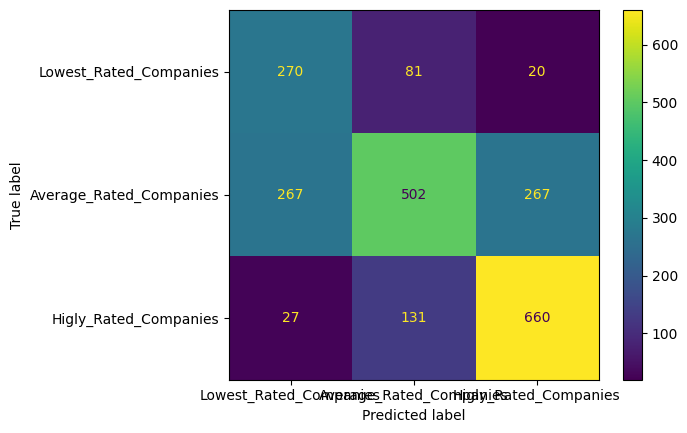

In [186]:
model = LogisticRegression(random_state=42, multi_class='multinomial', C=100.0, max_iter=200, penalty='l2', solver='newton-cg')
model.fit(x_train_optimal_features, y_train)
pred = model.predict(x_test_optimal_features)
report = metrics.classification_report(y_test, pred, target_names=labels)
print(report)
print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, pred)))
print("f1_score: {:0.3f}".format(metrics.f1_score(y_test, pred, average='macro')))
cm = confusion_matrix(y_test, pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

# Neural Network MLP Classifier All Features

In [187]:
neuron_values = [1, 5, 10, 20, 50, 70, 100, 120, 150, 200, 300]
alpha_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
# create empty lists to store F1 scores
test_f1_scores = np.zeros((len(neuron_values), len(alpha_values)))
train_f1_scores = np.zeros((len(neuron_values), len(alpha_values)))

# loop over neuron values and alpha values
for n_neurons in neuron_values:
    for alpha in alpha_values:
        # create and fit the MLP classifier
        mlp = MLPClassifier(hidden_layer_sizes=(n_neurons,  ), alpha=alpha, max_iter=1000, random_state = 42)
        mlp.fit(x_train, y_train)

        # evaluate the performance of the classifier on training data
        y_train_pred = mlp.predict(x_train)
        train_f1 = f1_score(y_train, y_train_pred, average='macro')

        # evaluate the performance of the classifier on test data
        y_test_pred = mlp.predict(x_test)
        test_f1 = f1_score(y_test, y_test_pred, average='macro')

        # store the F1 scores
        test_f1_scores[neuron_values.index(n_neurons), alpha_values.index(alpha)] = test_f1
        train_f1_scores[neuron_values.index(n_neurons), alpha_values.index(alpha)] = train_f1
        # print the results
        print(f"n_neurons={n_neurons}, alpha={alpha:.4f}, Train F1 score={train_f1:.4f}, Test F1 score={test_f1:.4f}")

n_neurons=1, alpha=0.0001, Train F1 score=0.6730, Test F1 score=0.5733
n_neurons=1, alpha=0.0005, Train F1 score=0.6732, Test F1 score=0.5733
n_neurons=1, alpha=0.0010, Train F1 score=0.6731, Test F1 score=0.5733
n_neurons=1, alpha=0.0050, Train F1 score=0.6734, Test F1 score=0.5736
n_neurons=1, alpha=0.0100, Train F1 score=0.6735, Test F1 score=0.5746
n_neurons=1, alpha=0.0500, Train F1 score=0.6735, Test F1 score=0.5758
n_neurons=1, alpha=0.1000, Train F1 score=0.6719, Test F1 score=0.5750
n_neurons=1, alpha=0.5000, Train F1 score=0.6713, Test F1 score=0.5788
n_neurons=1, alpha=1.0000, Train F1 score=0.6653, Test F1 score=0.5784
n_neurons=5, alpha=0.0001, Train F1 score=0.7626, Test F1 score=0.6341
n_neurons=5, alpha=0.0005, Train F1 score=0.7612, Test F1 score=0.6396
n_neurons=5, alpha=0.0010, Train F1 score=0.7614, Test F1 score=0.6401
n_neurons=5, alpha=0.0050, Train F1 score=0.7589, Test F1 score=0.6397
n_neurons=5, alpha=0.0100, Train F1 score=0.7596, Test F1 score=0.6404
n_neur

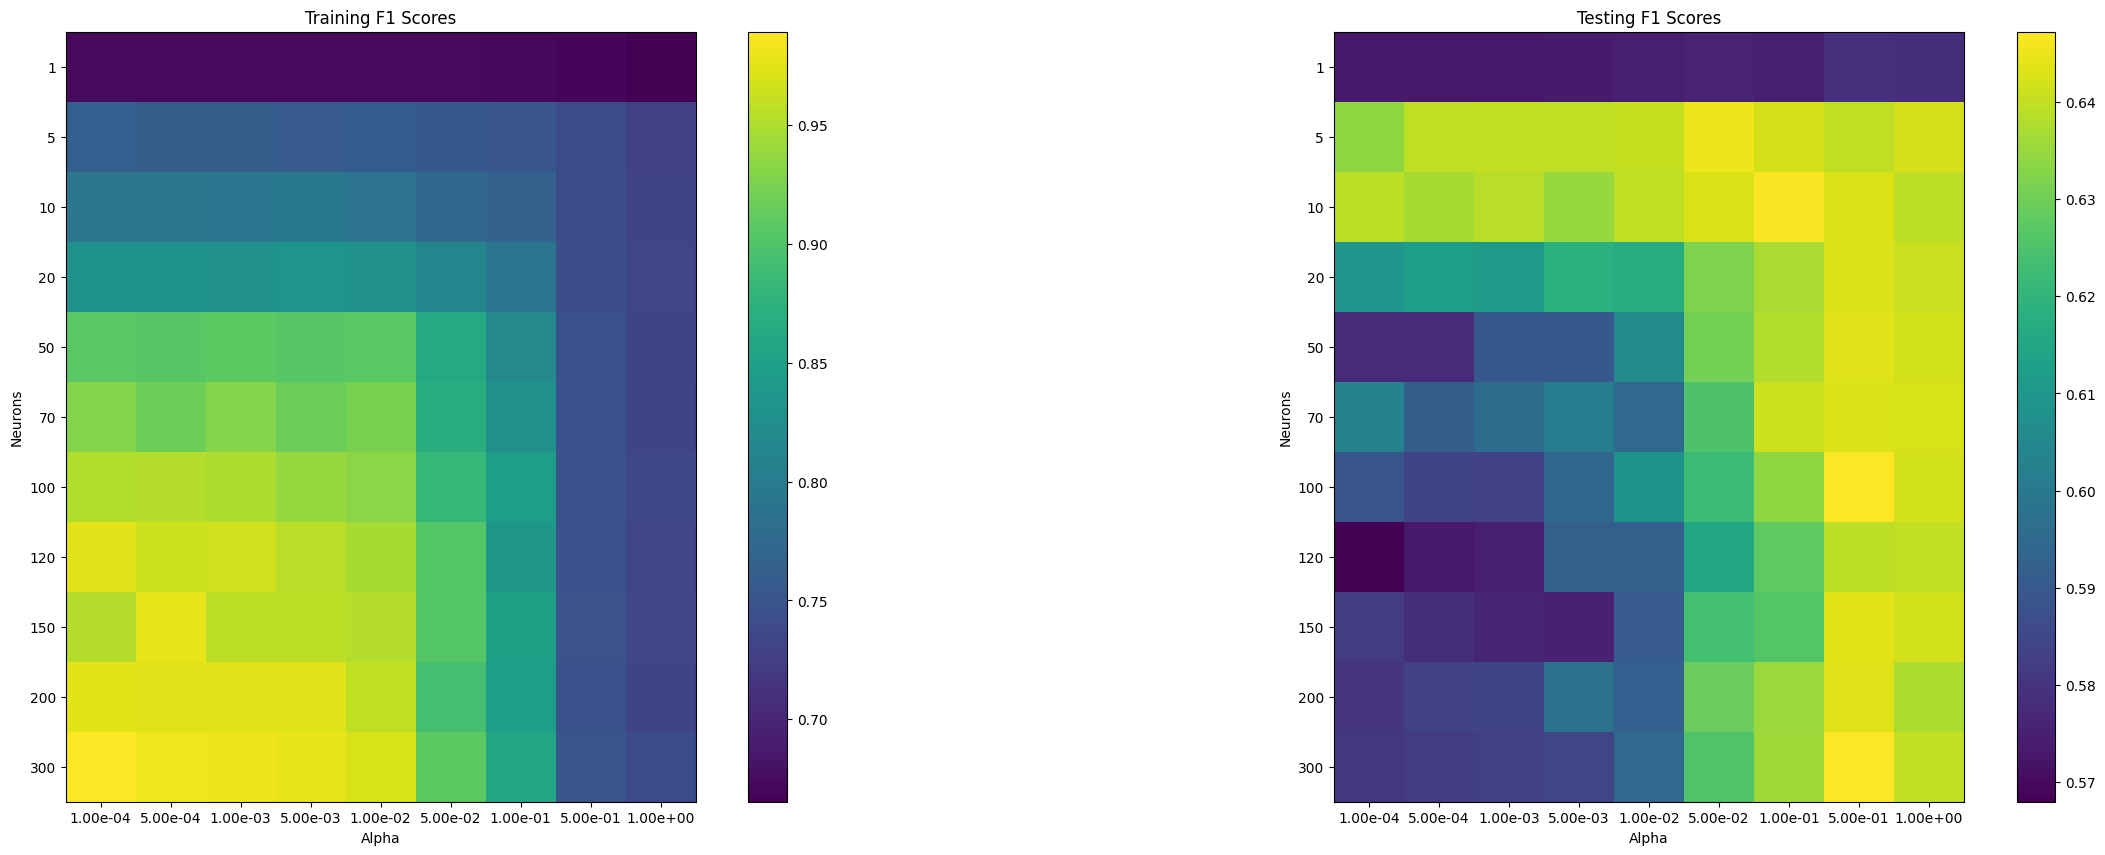

In [188]:
# reshape the F1 scores as 2D arrays for plotting
train_f1_scores = np.array(train_f1_scores).reshape(len(neuron_values), len(alpha_values))
test_f1_scores = np.array(test_f1_scores).reshape(len(neuron_values), len(alpha_values))

# create subplots for training and testing F1 scores
fig, axs = plt.subplots(1, 2, figsize=(30, 10))

# plot training F1 scores
im_1 = axs[0].imshow(train_f1_scores, cmap='viridis')
axs[0].set_title('Training F1 Scores')
axs[0].set_xlabel('Alpha')
axs[0].set_ylabel('Neurons')
axs[0].set_xticks(np.arange(len(alpha_values)))
axs[0].set_xticklabels([f'{alpha:.2e}' for alpha in alpha_values])
axs[0].set_yticks(np.arange(len(neuron_values)))
axs[0].set_yticklabels(neuron_values)

# plot testing F1 scores
im_2 = axs[1].imshow(test_f1_scores, cmap='viridis')
axs[1].set_title('Testing F1 Scores')
axs[1].set_xlabel('Alpha')
axs[1].set_ylabel('Neurons')
axs[1].set_xticks(np.arange(len(alpha_values)))
axs[1].set_xticklabels([f'{alpha:.2e}' for alpha in alpha_values])
axs[1].set_yticks(np.arange(len(neuron_values)))
axs[1].set_yticklabels(neuron_values, linespacing=20)

# add colorbar
fig.colorbar(im_1, ax=axs[0])
fig.colorbar(im_2, ax=axs[1])

# show the plot
plt.show()

In [189]:
ind = np.unravel_index(np.argmax(test_f1_scores, axis=None), test_f1_scores.shape)
print(f'Best F1_score = {test_f1_scores[ind]} with hyperparameters: neurons={neuron_values[ind[0]]}, alpha={alpha_values[ind[1]]}')


Best F1_score = 0.6472599247692353 with hyperparameters: neurons=300, alpha=0.5


# Neural Network MLP Classifer Optimal Features

In [190]:
neuron_values = [1, 5, 10, 20, 50, 70, 100, 120, 150, 200, 300]
alpha_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]

# create empty lists to store F1 scores
train_f1_scores = []
test_f1_scores = []

# loop over neuron values and alpha values
for n_neurons in neuron_values:
    for alpha in alpha_values:
        # create and fit the MLP classifier
        mlp = MLPClassifier(hidden_layer_sizes=(n_neurons,  ), alpha=alpha, max_iter=1000, random_state = 42)
        mlp.fit(x_train_optimal_features, y_train)

        # evaluate the performance of the classifier on training data
        y_train_pred = mlp.predict(x_train_optimal_features)
        train_f1 = f1_score(y_train, y_train_pred, average='macro')

        # evaluate the performance of the classifier on test data
        y_test_pred = mlp.predict(x_test_optimal_features)
        test_f1 = f1_score(y_test, y_test_pred, average='macro')

        # store the F1 scores
        train_f1_scores.append(train_f1)
        test_f1_scores.append(test_f1)

        # print the results
        print(f"n_neurons={n_neurons}, alpha={alpha:.4f}, Train F1 score={train_f1:.4f}, Test F1 score={test_f1:.4f}")

n_neurons=1, alpha=0.0001, Train F1 score=0.6582, Test F1 score=0.5699
n_neurons=1, alpha=0.0005, Train F1 score=0.6583, Test F1 score=0.5699
n_neurons=1, alpha=0.0010, Train F1 score=0.6583, Test F1 score=0.5699
n_neurons=1, alpha=0.0050, Train F1 score=0.6580, Test F1 score=0.5699
n_neurons=1, alpha=0.0100, Train F1 score=0.6580, Test F1 score=0.5699
n_neurons=1, alpha=0.0500, Train F1 score=0.6570, Test F1 score=0.5703
n_neurons=1, alpha=0.1000, Train F1 score=0.6557, Test F1 score=0.5707
n_neurons=1, alpha=0.5000, Train F1 score=0.6525, Test F1 score=0.5707
n_neurons=1, alpha=1.0000, Train F1 score=0.6457, Test F1 score=0.5646
n_neurons=5, alpha=0.0001, Train F1 score=0.7331, Test F1 score=0.6442
n_neurons=5, alpha=0.0005, Train F1 score=0.7328, Test F1 score=0.6438
n_neurons=5, alpha=0.0010, Train F1 score=0.7329, Test F1 score=0.6439
n_neurons=5, alpha=0.0050, Train F1 score=0.7324, Test F1 score=0.6444
n_neurons=5, alpha=0.0100, Train F1 score=0.7327, Test F1 score=0.6451
n_neur

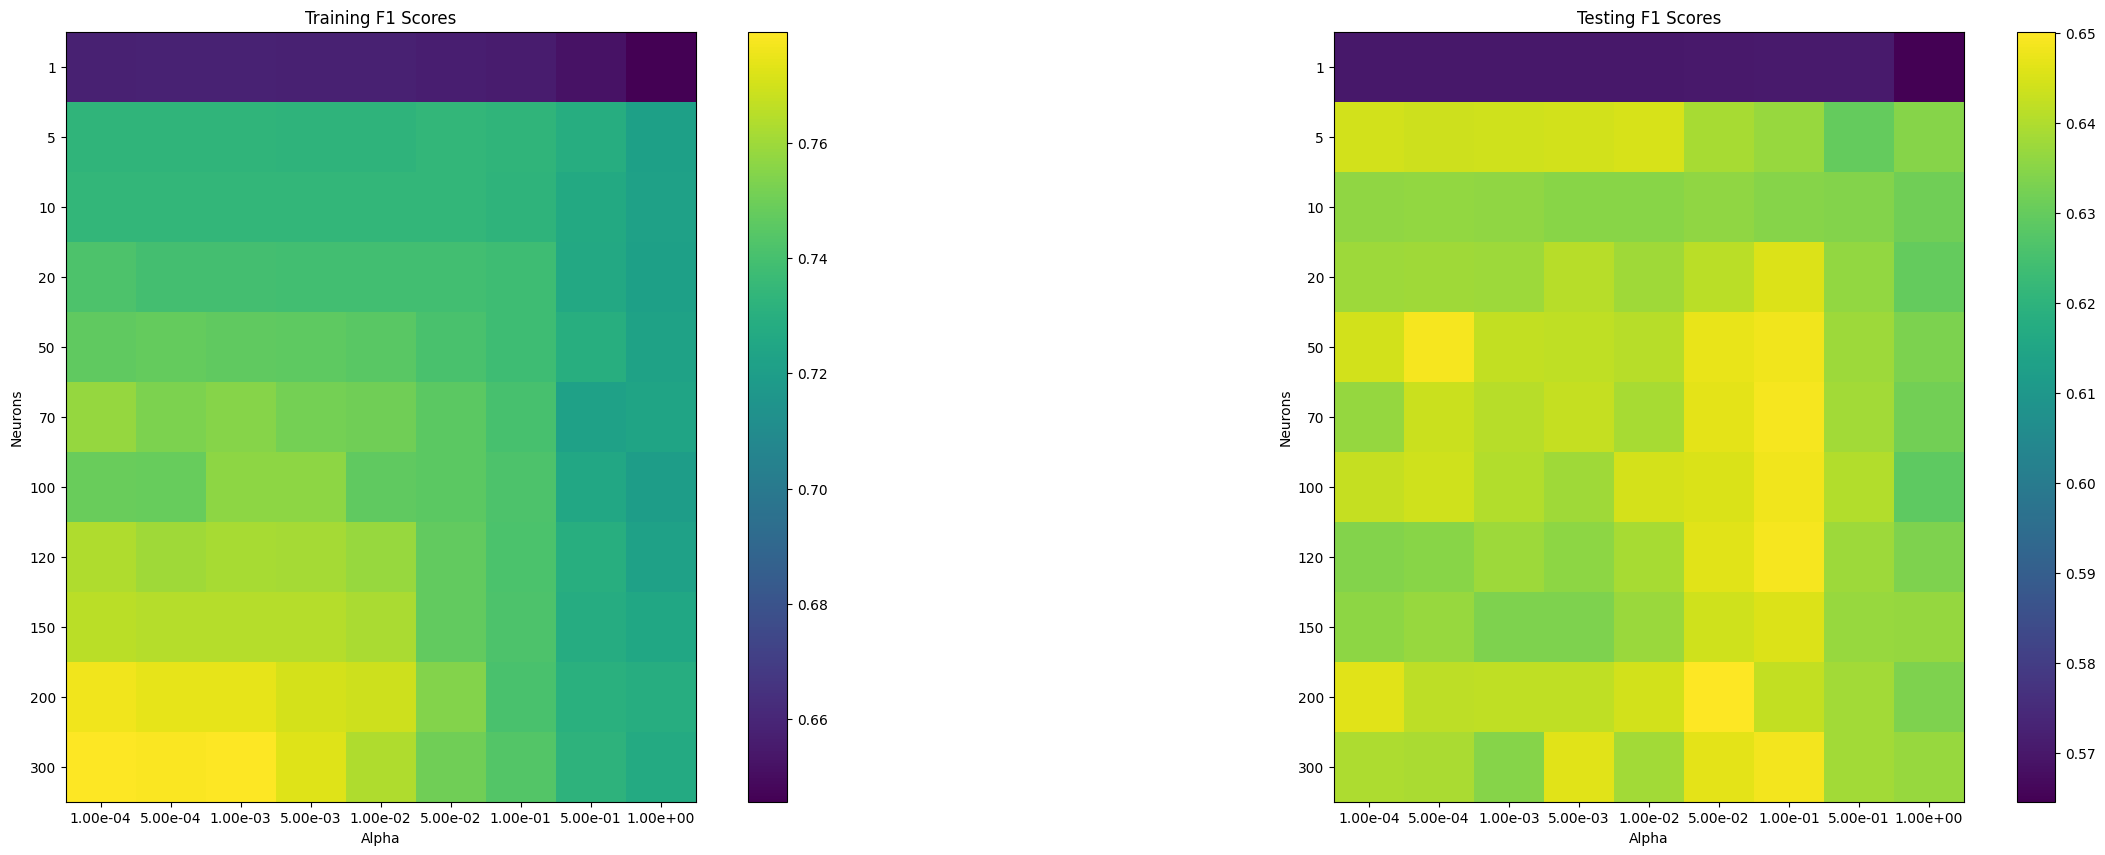

In [191]:
# reshape the F1 scores as 2D arrays for plotting
train_f1_scores = np.array(train_f1_scores).reshape(len(neuron_values), len(alpha_values))
test_f1_scores = np.array(test_f1_scores).reshape(len(neuron_values), len(alpha_values))

# create subplots for training and testing F1 scores
fig, axs = plt.subplots(1, 2, figsize=(30, 10))

# plot training F1 scores
im_1 = axs[0].imshow(train_f1_scores, cmap='viridis')
axs[0].set_title('Training F1 Scores')
axs[0].set_xlabel('Alpha')
axs[0].set_ylabel('Neurons')
axs[0].set_xticks(np.arange(len(alpha_values)))
axs[0].set_xticklabels([f'{alpha:.2e}' for alpha in alpha_values])
axs[0].set_yticks(np.arange(len(neuron_values)))
axs[0].set_yticklabels(neuron_values)

# plot testing F1 scores
im_2 = axs[1].imshow(test_f1_scores, cmap='viridis')
axs[1].set_title('Testing F1 Scores')
axs[1].set_xlabel('Alpha')
axs[1].set_ylabel('Neurons')
axs[1].set_xticks(np.arange(len(alpha_values)))
axs[1].set_xticklabels([f'{alpha:.2e}' for alpha in alpha_values])
axs[1].set_yticks(np.arange(len(neuron_values)))
axs[1].set_yticklabels(neuron_values, linespacing=20)

# add colorbar
fig.colorbar(im_1, ax=axs[0])
fig.colorbar(im_2, ax=axs[1])

# show the plot
plt.show()

In [192]:
ind = np.unravel_index(np.argmax(test_f1_scores, axis=None), test_f1_scores.shape)
print(f'Best F1_score = {test_f1_scores[ind]} with hyperparameters: neurons={neuron_values[ind[0]]}, alpha={alpha_values[ind[1]]}')

Best F1_score = 0.6501695766203665 with hyperparameters: neurons=200, alpha=0.05
